In [1]:
%matplotlib inline

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from plotnine import *
import numpy as np

import plotly.figure_factory as FF
import chart_studio.plotly as py

from IPython.display import Image

%load_ext rpy2.ipython

from pylab import rcParams
size = 20
params = {'legend.fontsize': size,
          'figure.figsize': (15, 5),
         'axes.labelsize': size, 
         'axes.titlesize':size, 
         'xtick.labelsize':size, 
         'ytick.labelsize':size, 
          'axes.titlesize':1.5*size, 
         'figure.figsize': (12, 12)}
rcParams.update(params)
theme_update(figure_size=(9, 9), title=element_text(size=size), text=element_text(size=.6*size)) # for plotnine

/Users/tdhopper/miniconda2/envs/pythonplot/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
%%R
install.packages("ggplot2", repos='http://cran.us.r-project.org')
library(ggplot2) 
theme_set(theme_grey(base_size = 24))

/Users/tdhopper/miniconda2/envs/pythonplot/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning:

trying URL 'http://cran.us.r-project.org/src/contrib/ggplot2_2.2.1.tar.gz'


/Users/tdhopper/miniconda2/envs/pythonplot/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning:

Content type 'application/x-gzip'

/Users/tdhopper/miniconda2/envs/pythonplot/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning:

 length 2213308 bytes (2.1 MB)


/Users/tdhopper/miniconda2/envs/pythonplot/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning:

=

/Users/tdhopper/miniconda2/envs/pythonplot/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning:




/Users/tdhopper/miniconda2/envs/pythonplot/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning:

downloaded 2.1 MB



/Users/tdhopper/miniconda2/envs/pythonplot/lib/python3.6/site-packages/rpy2/rinterface/__init__.

Outline

* Plots 
    * Bar 
    * Histogram
    * Scatter 
    * Box and whisker
    * Line 
        * Time series
* Extensions
    * Faceting on categorical
    * Stacked bar/histogram
    * Line over scatter
    * Multi color/symbol scatter
    * Multiple line plots
* Modifications
    * Log scaled axes
    * Time labeled axes
    * Histogram bin-width
    * Aspect ratio
    * Axis boundaries


## Load Data

Data is from [ggplot2](http://ggplot2.tidyverse.org/reference/mpg.html).

Many ggplot examples taken from [R for data science](http://r4ds.had.co.nz/visualize.html) by Garrett Grolemund and Hadley Wickham.

In [3]:
%%R
summary(mpg)

 manufacturer          model               displ            year     
 Length:234         Length:234         Min.   :1.600   Min.   :1999  
 Class :character   Class :character   1st Qu.:2.400   1st Qu.:1999  
 Mode  :character   Mode  :character   Median :3.300   Median :2004  
                                       Mean   :3.472   Mean   :2004  
                                       3rd Qu.:4.600   3rd Qu.:2008  
                                       Max.   :7.000   Max.   :2008  
      cyl           trans               drv                 cty       
 Min.   :4.000   Length:234         Length:234         Min.   : 9.00  
 1st Qu.:4.000   Class :character   Class :character   1st Qu.:14.00  
 Median :6.000   Mode  :character   Mode  :character   Median :17.00  
 Mean   :5.889                                         Mean   :16.86  
 3rd Qu.:8.000                                         3rd Qu.:19.00  
 Max.   :8.000                                         Max.   :35.00  
      hwy    

In [4]:
mpg = pd.read_csv('https://raw.githubusercontent.com/tidyverse/ggplot2/master/data-raw/mpg.csv')
diamonds = pd.read_csv('https://raw.githubusercontent.com/tidyverse/ggplot2/master/data-raw/diamonds.csv')

ts = (pd
      .Series(np.random.randn(1000), 
              index=pd.date_range('1/1/2000', periods=1000))
      .cumsum()
      .to_frame()
      .reset_index()
     )
ts.columns = ['date', 'value']

In [5]:
from IPython.display import display, HTML
display(HTML(ts.head(5).to_html(index=False)))

date,value
2000-01-01,-0.604992
2000-01-02,2.997363
2000-01-03,3.650973
2000-01-04,2.366580
2000-01-05,3.146239


In [6]:
from IPython.display import display, HTML
display(HTML(mpg.head(5).to_html(index=False)))

manufacturer,model,displ,year,cyl,trans,drv,cty,hwy,fl,class
audi,a4,1.8,1999,4,auto(l5),f,18,29,p,compact
audi,a4,1.8,1999,4,manual(m5),f,21,29,p,compact
audi,a4,2.0,2008,4,manual(m6),f,20,31,p,compact
audi,a4,2.0,2008,4,auto(av),f,21,30,p,compact
audi,a4,2.8,1999,6,auto(l5),f,16,26,p,compact


In [7]:
from IPython.display import display, HTML
display(HTML(diamonds.head(5).to_html(index=False)))

carat,cut,color,clarity,depth,table,price,x,y,z
0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


## Plots

### Basic Plots

#### Bar Charts of Counts

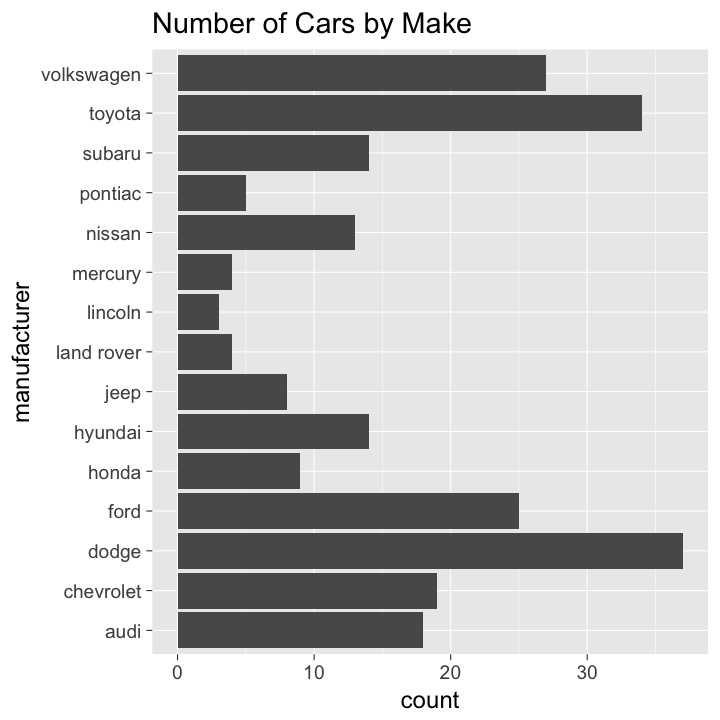

In [8]:
%%R -w 10 -h 10 -u in
ggplot(data=mpg) + 
    aes(x=manufacturer) + 
    geom_bar() + 
    coord_flip() +
    ggtitle("Number of Cars by Make")

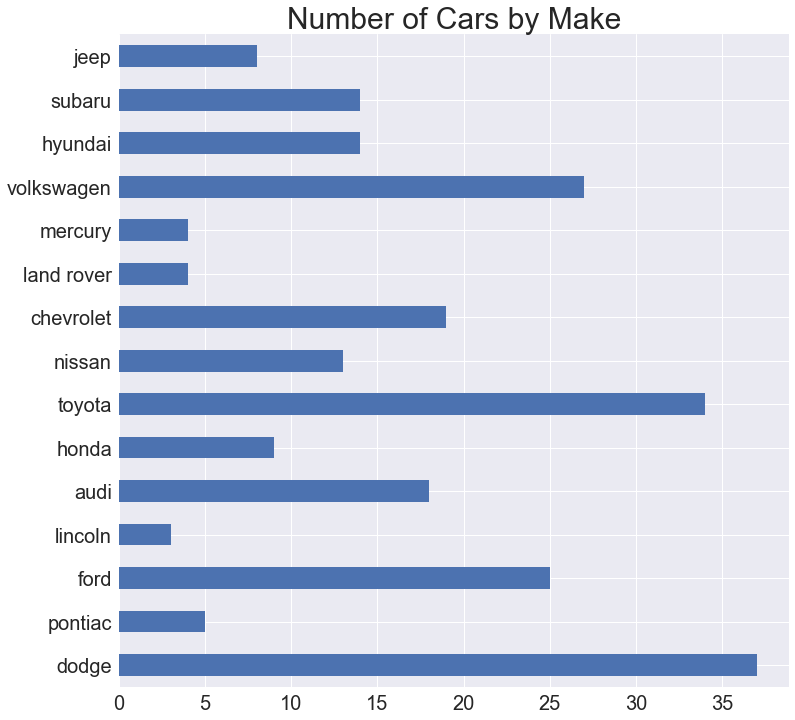

In [9]:
(mpg['manufacturer']
 .value_counts(sort=False)
 .plot.barh()
 .set_title('Number of Cars by Make')
);

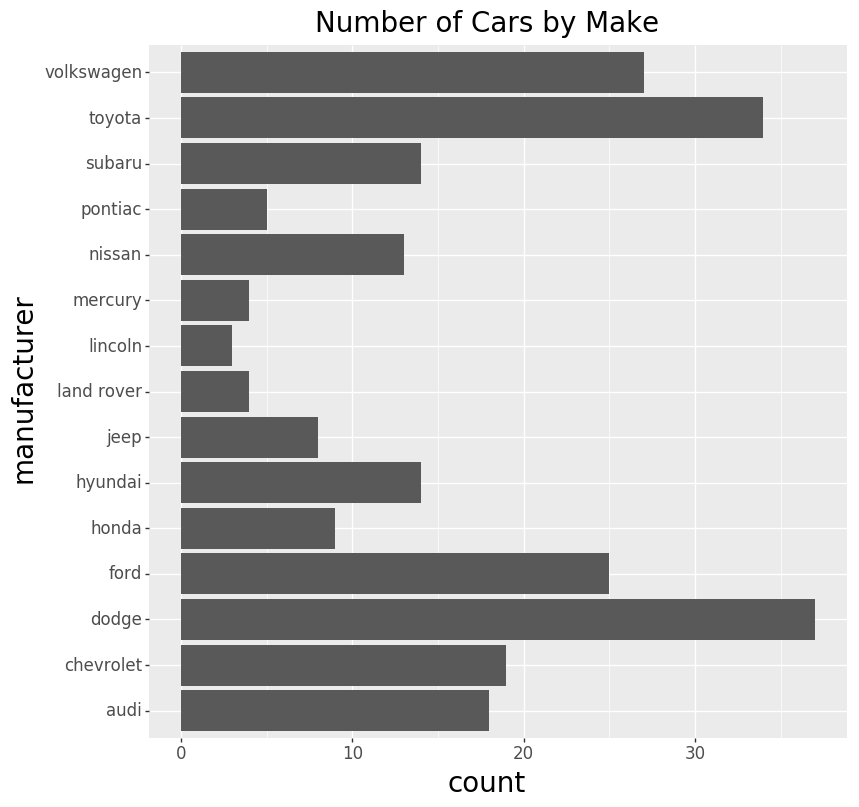

<ggplot: (285229965)>

In [10]:
"""plotnine gives an error on `ggplot(data=mpg)`.
"""
(ggplot(mpg) + 
   aes(x="manufacturer") +
   geom_bar(size=20) + 
   coord_flip() +
   ggtitle("Number of Cars by Make")
)

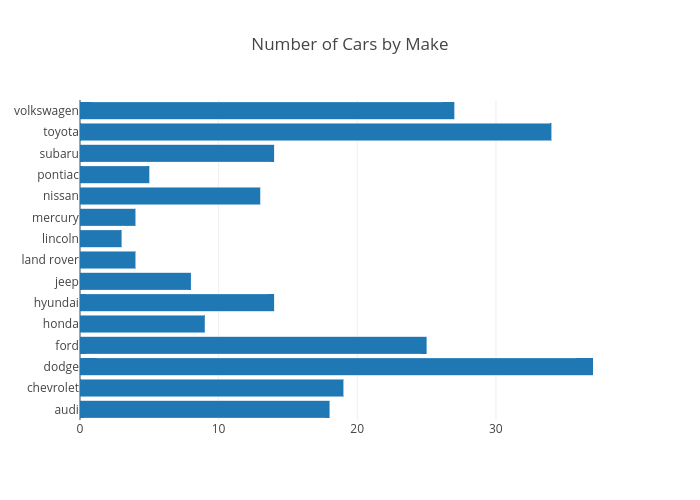

In [13]:
mpgGrouped = mpg.groupby('manufacturer').size()
fig = {
    'data' : [{
        'type' : 'bar',
        'x' : mpgGrouped.values.tolist(),
        'y' : mpgGrouped.index.tolist(),
        'orientation' : 'h'
        
    }],
    'layout' : {
        'title' : 'Number of Cars by Make'
    }
}

py.image.ishow(fig)

#### Histogram of Continuous Values

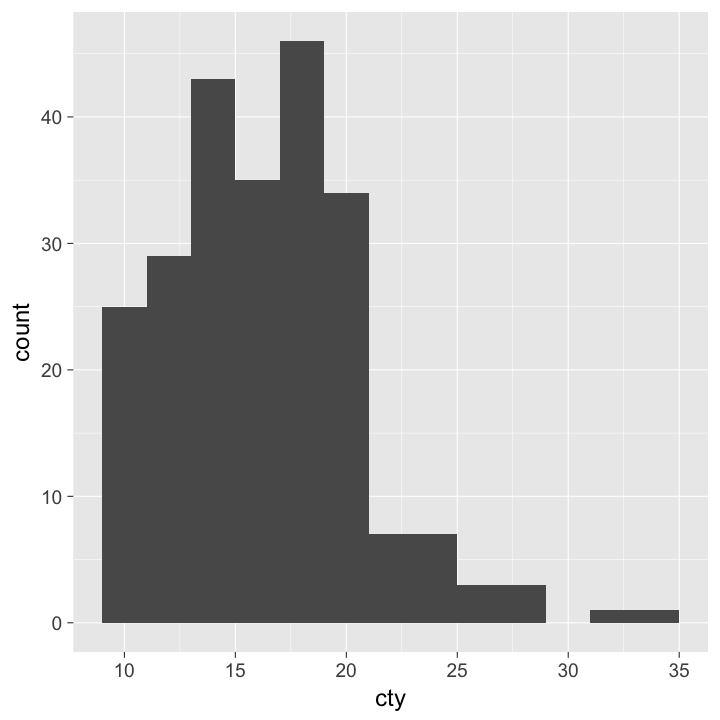

In [14]:
%%R -w 10 -h 10 -u in
ggplot(data=mpg) + 
    aes(x=cty) + 
    geom_histogram(binwidth=2)

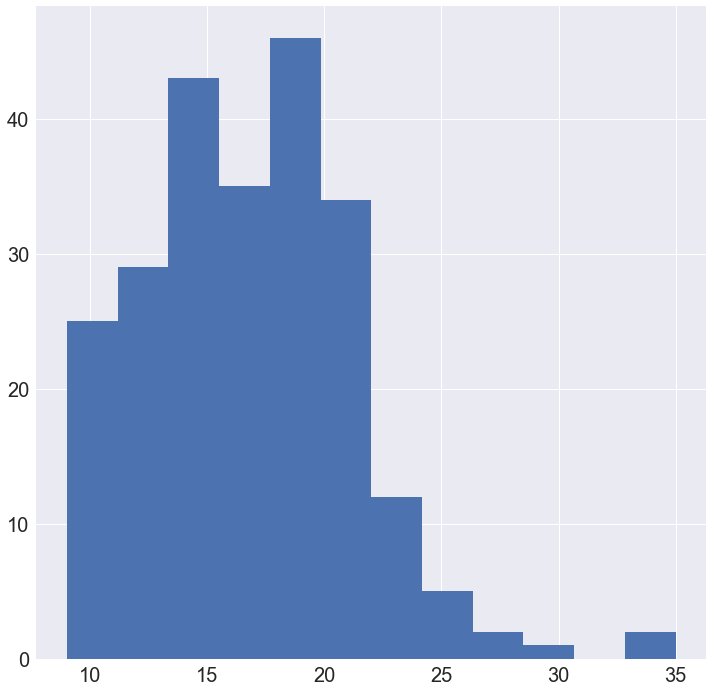

In [15]:
plt.hist('cty', bins=12, data=mpg);

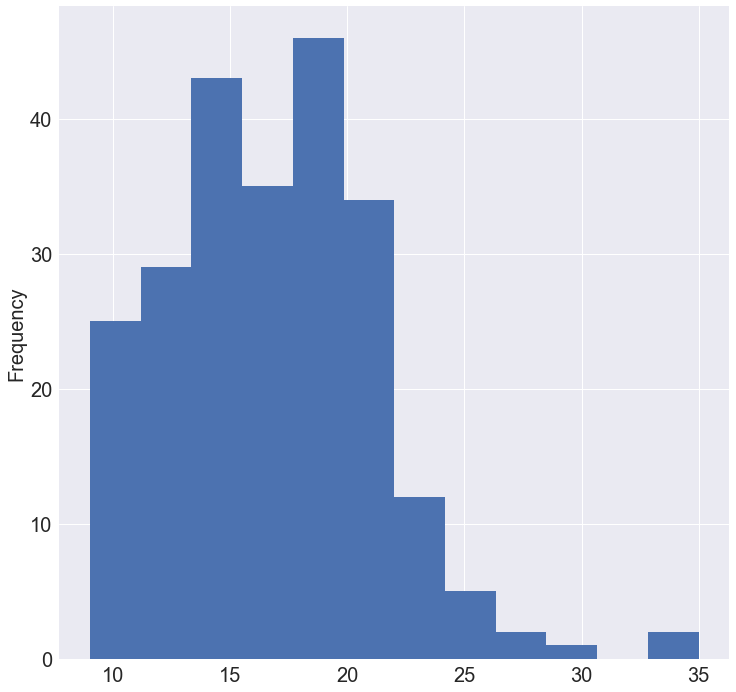

In [16]:
(mpg['cty']
 .plot
 .hist(bins=12));

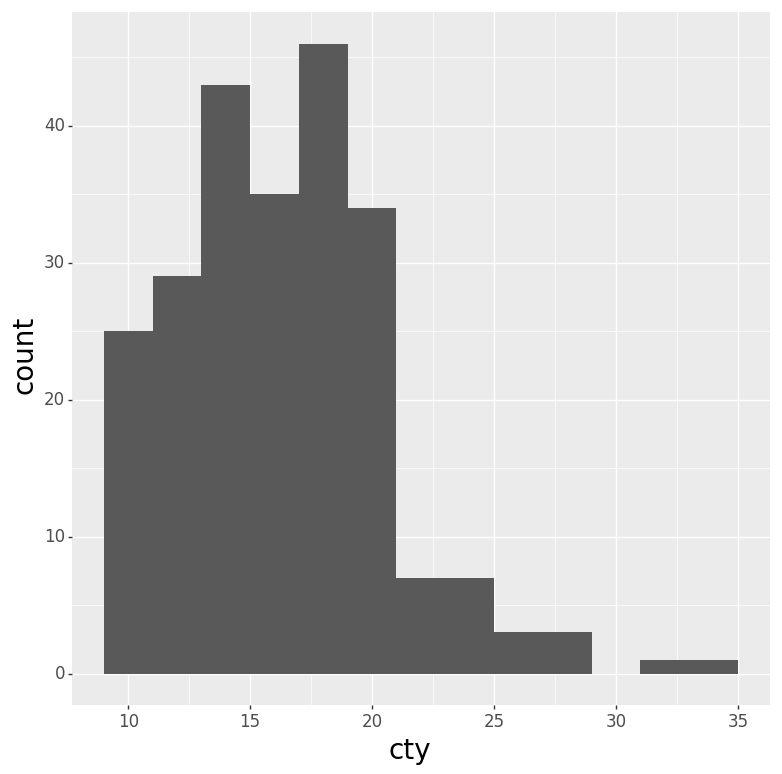

<ggplot: (-9223372036571381318)>

In [17]:
(ggplot(mpg) + 
    aes(x="cty") +
    geom_histogram(binwidth=2))

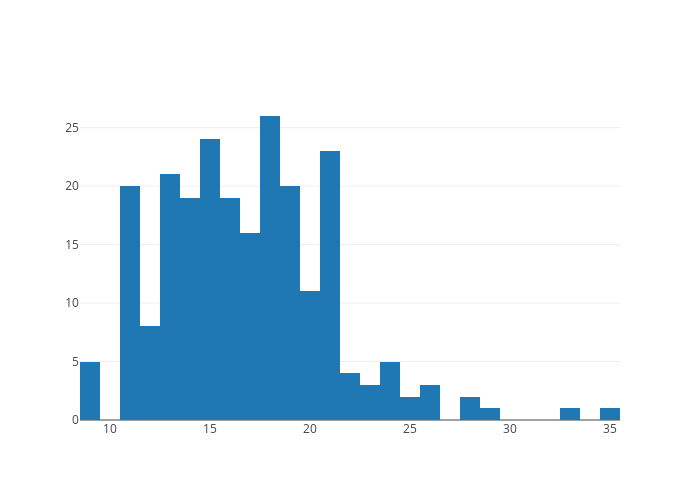

In [18]:
fig = {
    'data' : [{
        'type' : 'histogram',
        'x' : mpg['cty'],
    }],
}
py.image.ishow(fig)

#### Scatter Plot

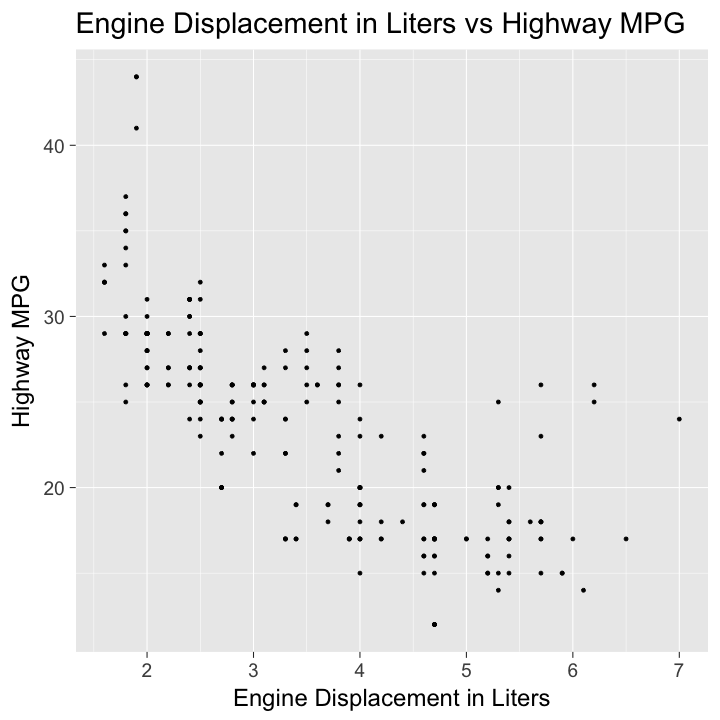

In [19]:
%%R -w 10 -h 10 -u in 
ggplot(data = mpg) +
    aes(x = displ, y = hwy) +
    geom_point() + 
    ggtitle("Engine Displacement in Liters vs Highway MPG") +
    xlab("Engine Displacement in Liters") +
    ylab("Highway MPG")

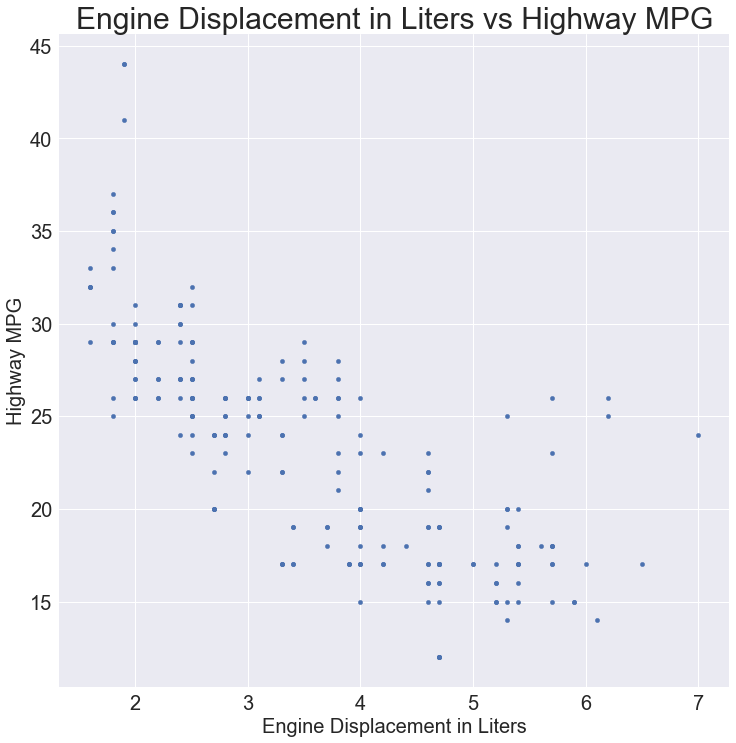

In [20]:
(mpg
 .plot
 .scatter(x='displ', y='hwy')
 .set(title='Engine Displacement in Liters vs Highway MPG',
      xlabel='Engine Displacement in Liters',
      ylabel='Highway MPG'))

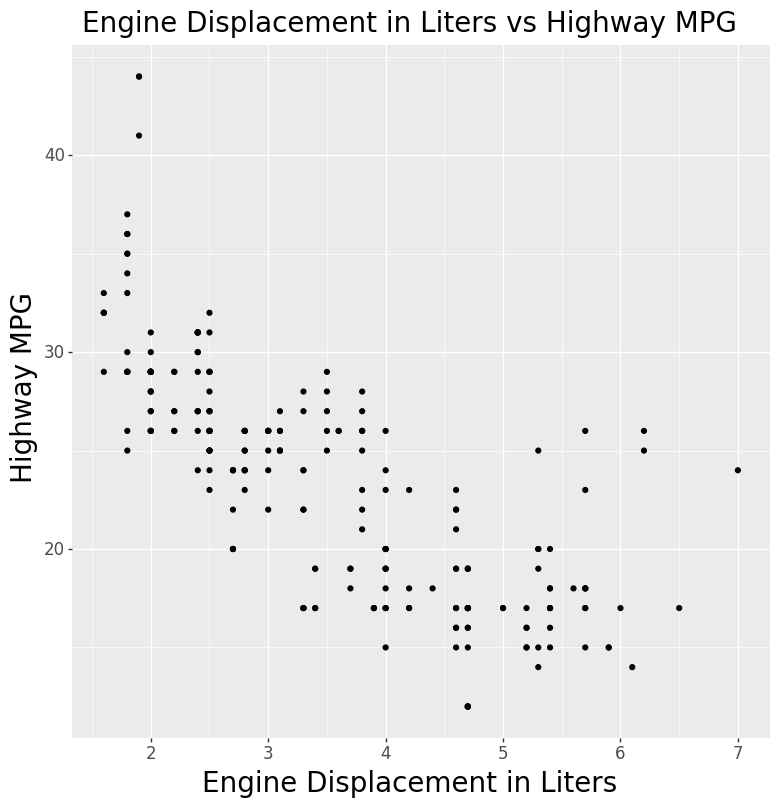

<ggplot: (-9223372036570920623)>

In [21]:
(ggplot(mpg) +
    aes(x = "displ", y = "hwy") +
    geom_point() + 
    ggtitle("Engine Displacement in Liters vs Highway MPG") +
    xlab("Engine Displacement in Liters") +
    ylab("Highway MPG"))

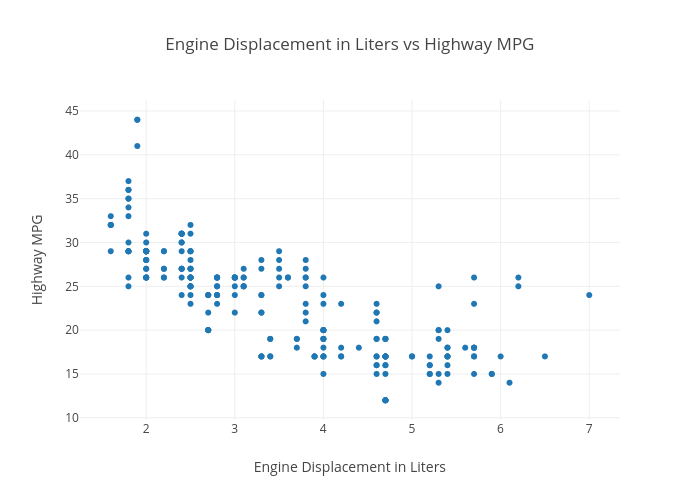

In [22]:
fig = {
    'data' : [{
        'type' : 'scatter',
        'mode' : 'markers',
        'x' : mpg.displ,
        'y' : mpg.hwy        
    }],
    'layout' : {
        'title' : 'Engine Displacement in Liters vs Highway MPG',
        'xaxis' : {
            'title' : 'Engine Displacement in Liters'
        },
        'yaxis' : {
            'title' : 'Highway MPG'
        }
    }
}
py.image.ishow(fig)

### Advanced Scatter Plotting

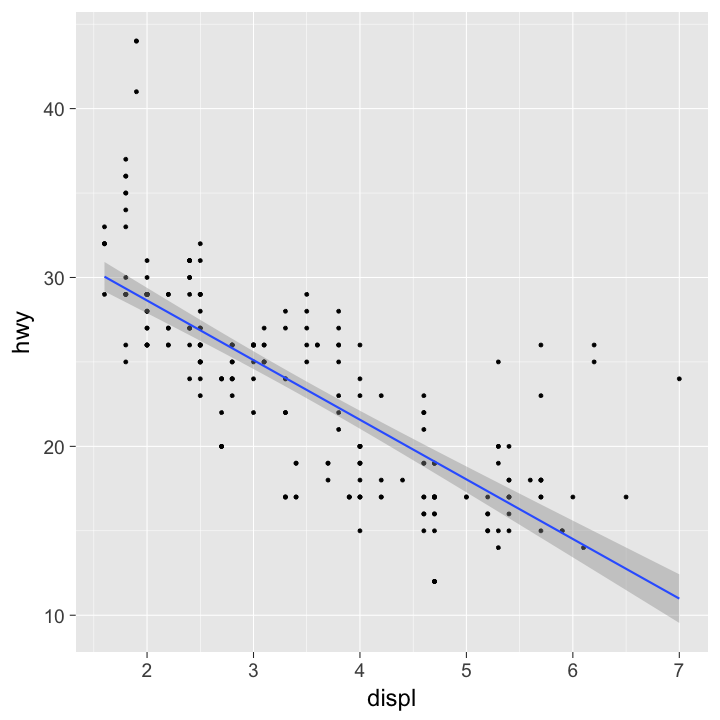

In [23]:
%%R -w 10 -h 10 -u in 
ggplot(data = mpg) +
    aes(x = displ, y = hwy) +
    geom_point() +
    geom_smooth(method=lm)

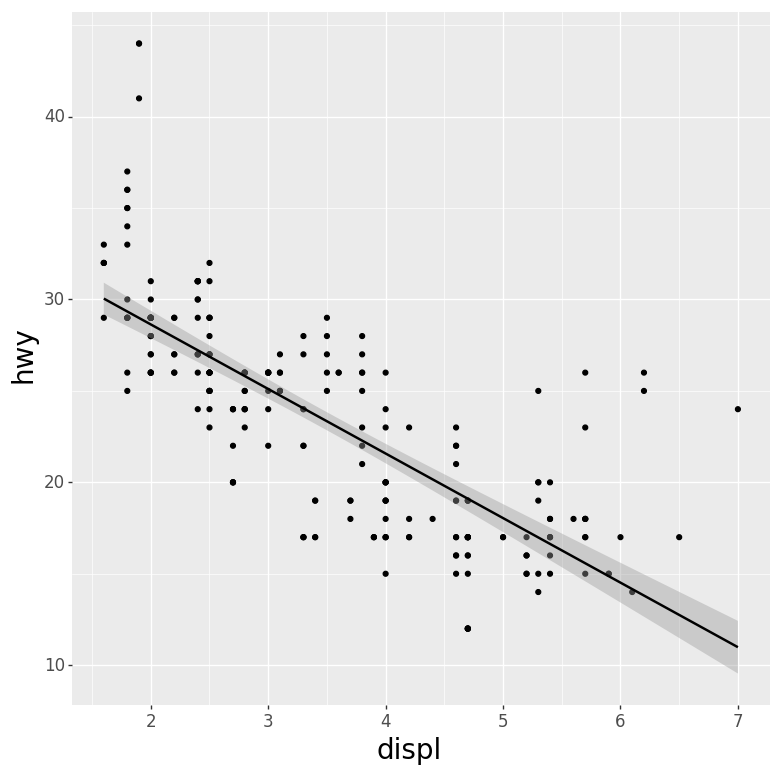

<ggplot: (283454742)>

In [24]:
(ggplot(mpg) +
    aes("displ", "hwy") +
    geom_point() +
    geom_smooth(method="lm"))

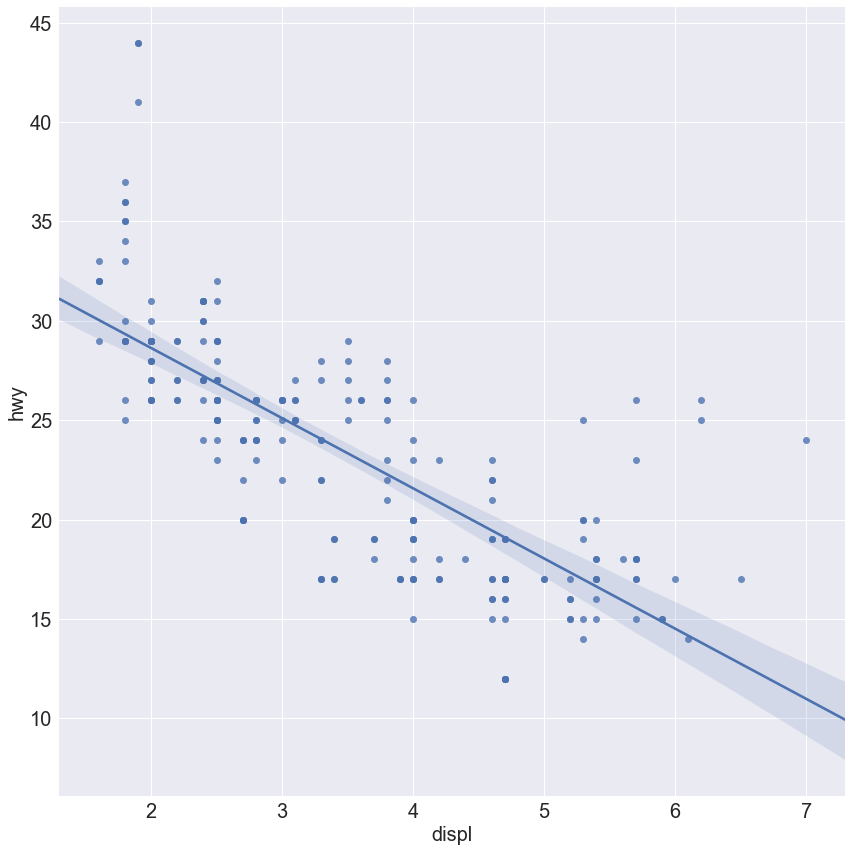

In [25]:
sns.lmplot(x="displ", y="hwy", 
           data=mpg, size=12)

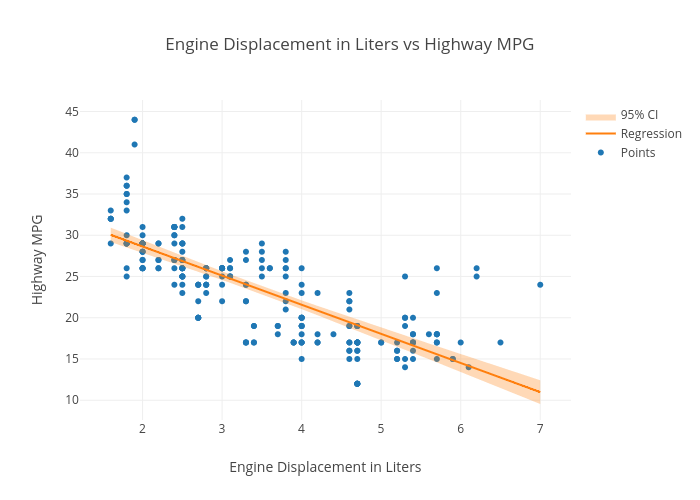

In [26]:
'''No built in method to calculate and display confidence intervals.
Must calculate manually and utilise existing features to build the confidence band.'''
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import summary_table

y=mpg.hwy
x=mpg.displ
X = sm.add_constant(x)
res = sm.OLS(y, X).fit()

st, data, ss2 = summary_table(res, alpha=0.05)
preds = pd.DataFrame.from_records(data, columns=[s.replace('\n', ' ') for s in ss2])
preds['displ'] = mpg.displ
preds = preds.sort_values(by='displ')

fig = {
    'data' : [{
        # Add the data points
            'type' : 'scatter',
            'mode' : 'markers',
            'x' : mpg.displ,
            'y' : mpg.hwy,
            'name' : 'Points'
    },
        {
            # Now the regression line
            'type' : 'scatter',
            'mode' : 'lines',
            'x' : preds['displ'],
            'y' : preds['Predicted Value'],
            'name' : 'Regression',
        },
        {
            #Add a lower bound for the confidence interval, white
            'type' : 'scatter',
            'mode' : 'lines',
            'x' : preds['displ'],
            'y' : preds['Mean ci 95% low'],
            'name' : 'Lower 95% CI',
            'showlegend' : False,
            'line' : {
                'color' : 'white'
            }
    },
        {
            #Upper bound for the confidence band, transparent but with fill
            'type' : 'scatter',
            'mode' : 'lines',
            'x' : preds['displ'],
            'y' : preds['Mean ci 95% upp'],
            'name' : '95% CI',
            'fill' : 'tonexty',
            'line' : {
                'color' : 'white'
            },
            'fillcolor' : 'rgba(255, 127, 14, 0.3)'
        }
        
    ],
    'layout' : {
        'title' : 'Engine Displacement in Liters vs Highway MPG',
        'xaxis' : {
            'title' : 'Engine Displacement in Liters'
        },
        'yaxis' : {
            'title' : 'Highway MPG'
        }
    }
}

py.image.ishow(fig)

#### Scatter Plot with Colors

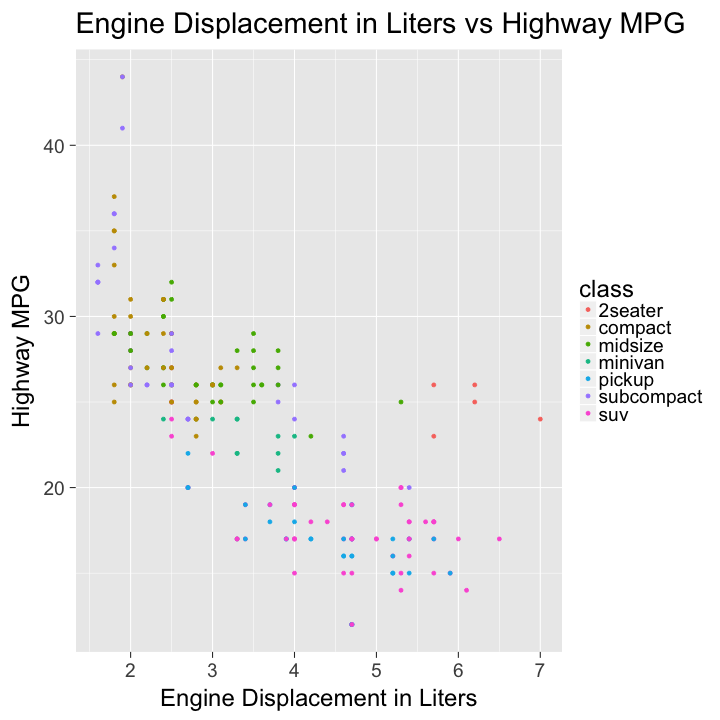

In [27]:
%%R -w 10 -h 10 -u in
ggplot(data = mpg) + 
    aes(x = displ, y = hwy, color = class) +
    geom_point() + 
    ggtitle("Engine Displacement in Liters vs Highway MPG") +
    xlab("Engine Displacement in Liters") +
    ylab("Highway MPG")

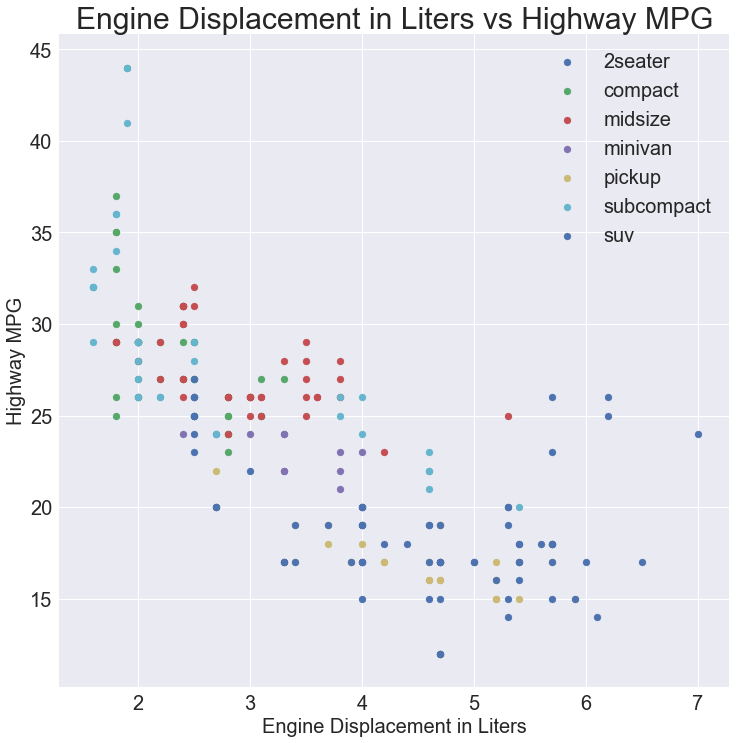

In [28]:
fig, ax = plt.subplots()
for c, df in mpg.groupby('class'):
    ax.scatter(df['displ'], df['hwy'], label=c)
ax.legend()
ax.set_title('Engine Displacement in Liters vs Highway MPG')
ax.set_xlabel('Engine Displacement in Liters')
ax.set_ylabel('Highway MPG');

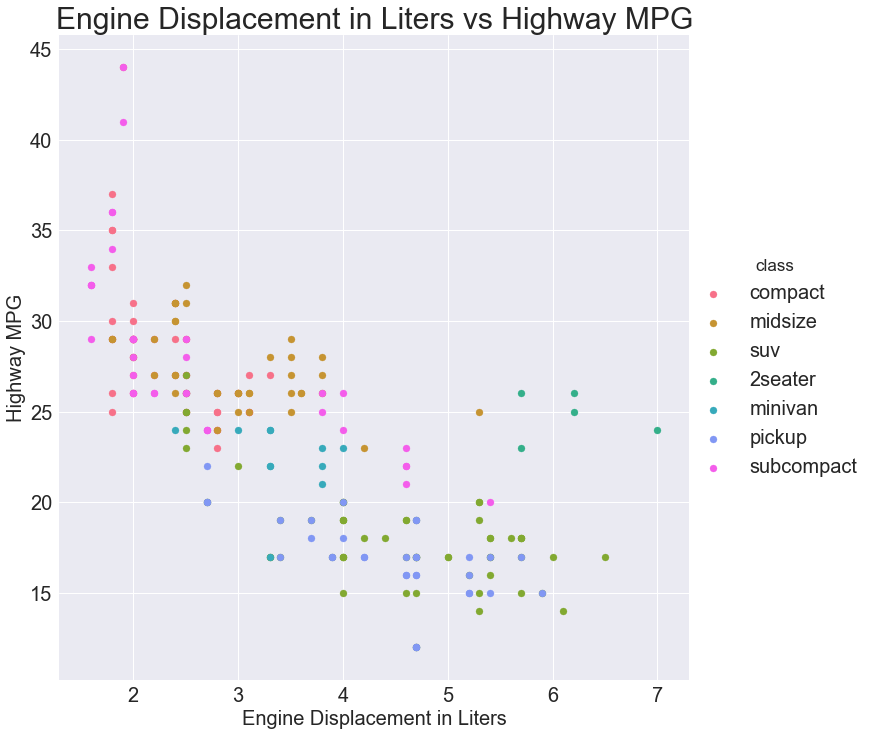

In [29]:
"""seaborn.FacetGrid overrides the `rcParams['figure.figsize'] global parameter. 
You have to set the size in the size with `size=` in `FacetGrid`"""
(sns
 .FacetGrid(mpg, hue="class", size=10)
 .map(plt.scatter, "displ", "hwy")
 .add_legend()
 .set(
    title="Engine Displacement in Liters vs Highway MPG",
    xlabel="Engine Displacement in Liters",
    ylabel="Highway MPG"
));

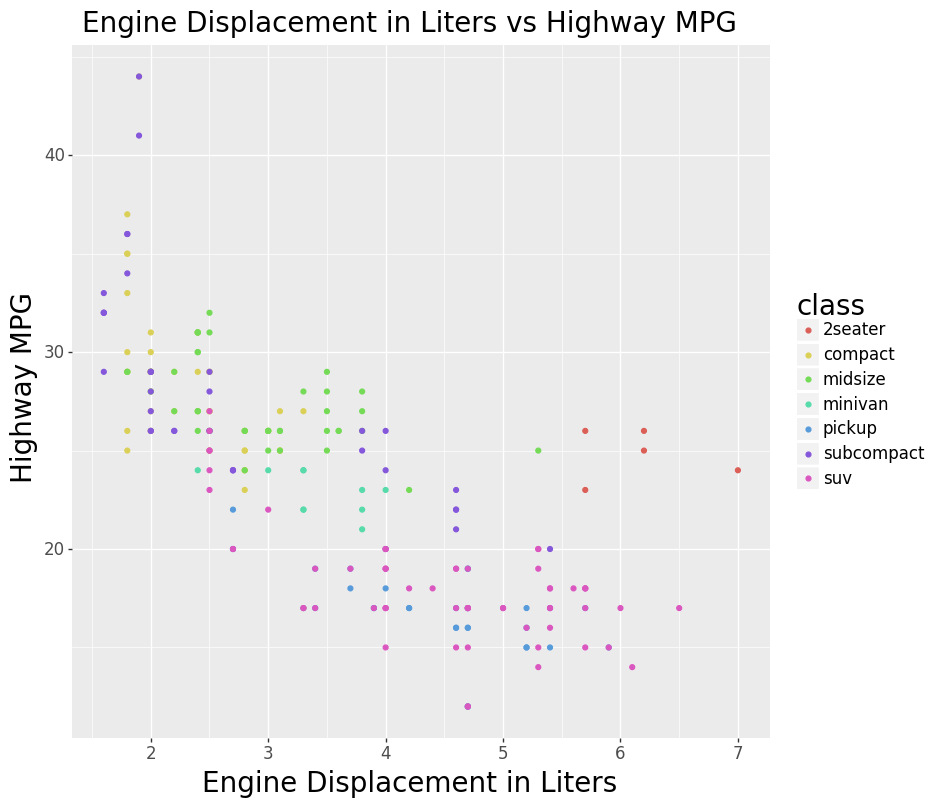

<ggplot: (-9223372036571391691)>

In [30]:
(ggplot(mpg) + 
    aes(x = "displ", y = "hwy", color = "class") +
    geom_point() + 
    ggtitle("Engine Displacement in Liters vs Highway MPG") +
    xlab("Engine Displacement in Liters") +
    ylab("Highway MPG"))

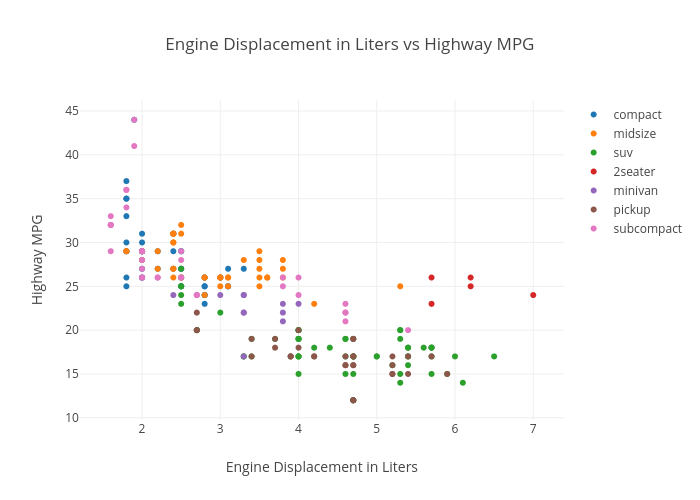

In [31]:
traces = []
for cls in mpg['class'].unique():
    traces.append({
        'type' : 'scatter',
        'mode' : 'markers',
        'x' : mpg.displ[mpg['class'] == cls],
        'y' : mpg.hwy[mpg['class'] == cls],
        'name' : cls
    })
    
fig = {
    'data' : traces,
    'layout' : {
        'title' : 'Engine Displacement in Liters vs Highway MPG',
        'xaxis' : {
            'title' : 'Engine Displacement in Liters',
        },
        'yaxis' : {
            'title' : 'Highway MPG'
        }
    }
}
py.image.ishow(fig)

#### Scatter Plot with Sizes and Transparency

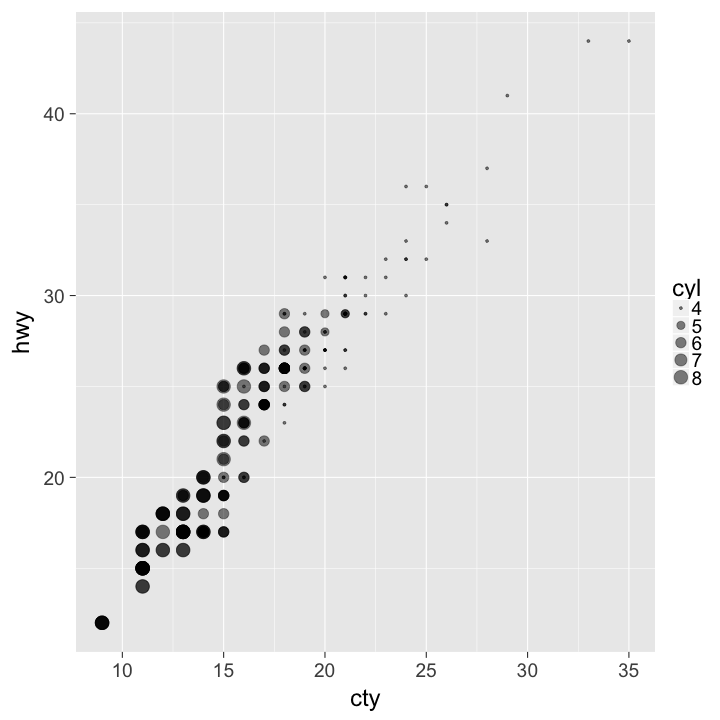

In [32]:
%%R -w 10 -h 10 -u in
ggplot(data = mpg) +
    aes(x = cty, y = hwy, size = cyl) +
    geom_point(alpha=.5)

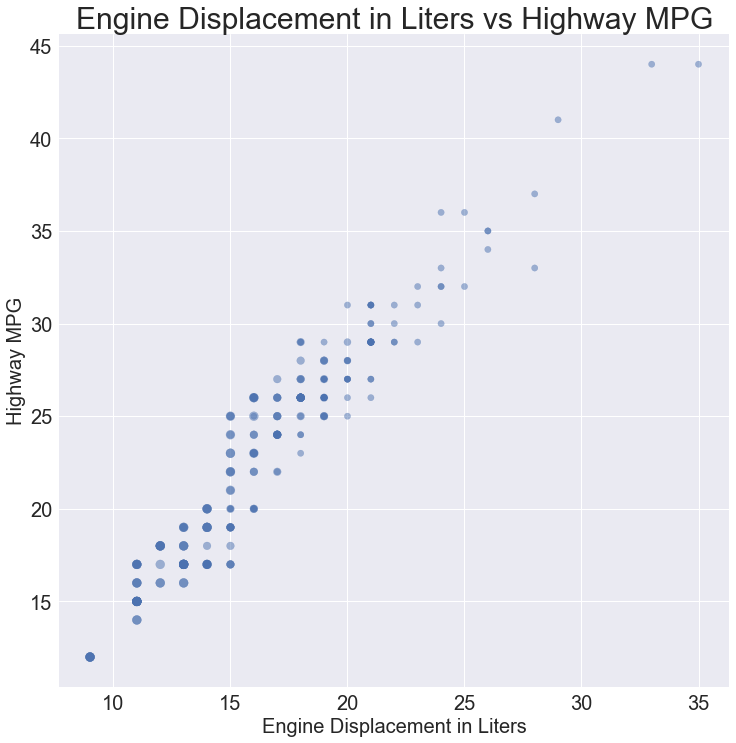

In [33]:
ax = (mpg
    .plot
    .scatter(x='cty', 
             y='hwy', 
             s=10*mpg['cyl'],
             alpha=.5))
ax.set_title('Engine Displacement in Liters vs Highway MPG')
ax.set_xlabel('Engine Displacement in Liters')
ax.set_ylabel('Highway MPG');

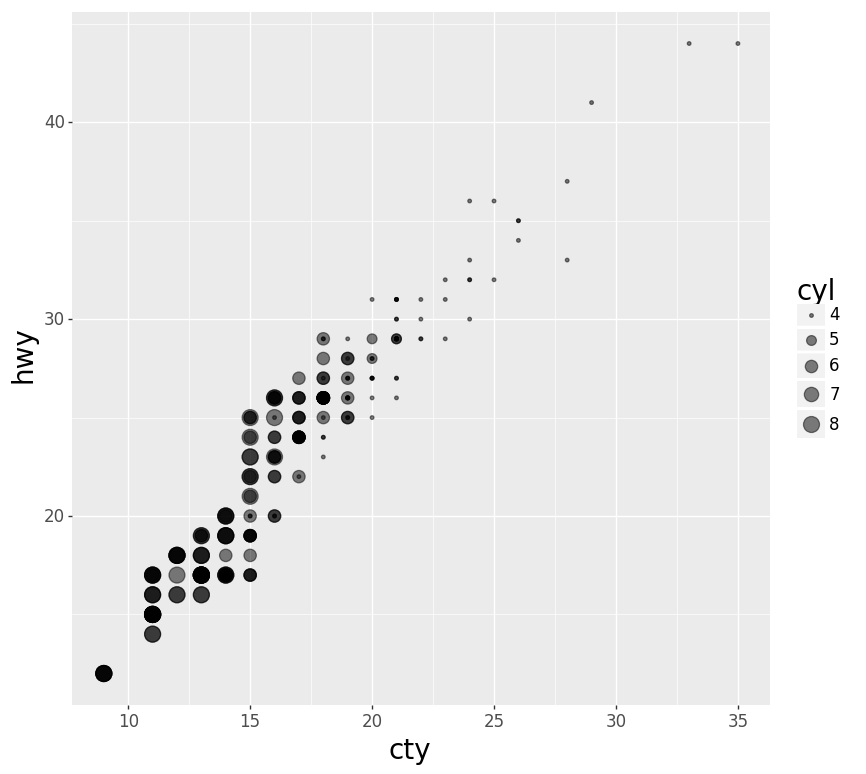

<ggplot: (286828913)>

In [34]:
(ggplot(mpg) +
    aes(x="cty", y="hwy", size="cyl") +
    geom_point(alpha=.5))

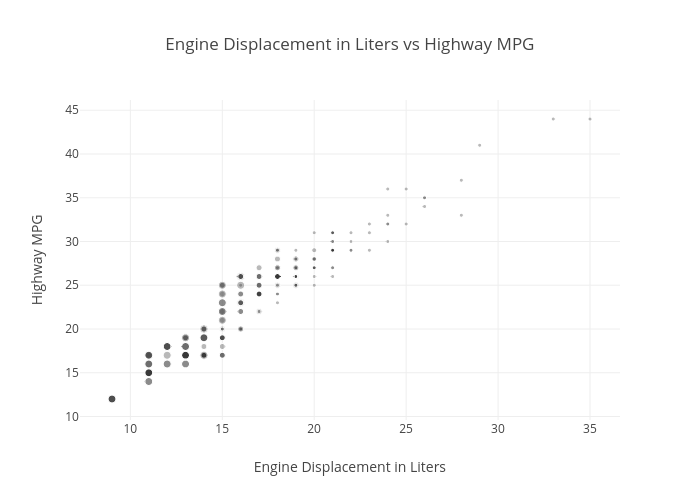

In [35]:
traces = [{
        'type' : 'scatter',
        'mode' : 'markers',
        'x' : mpg.cty,
        'y' : mpg.hwy,
        'marker' : {
            'size' : mpg.cyl,
            'color' : 'rgba(54,54,54,0.5)'
        },
        'name' : cls
    }]
    
fig = {
    'data' : traces,
    'layout' : {
        'title' : 'Engine Displacement in Liters vs Highway MPG',
        'xaxis' : {
            'title' : 'Engine Displacement in Liters',
        },
        'yaxis' : {
            'title' : 'Highway MPG'
        }
    }
}
py.image.ishow(fig)

#### Scatter Plot with Single Facet

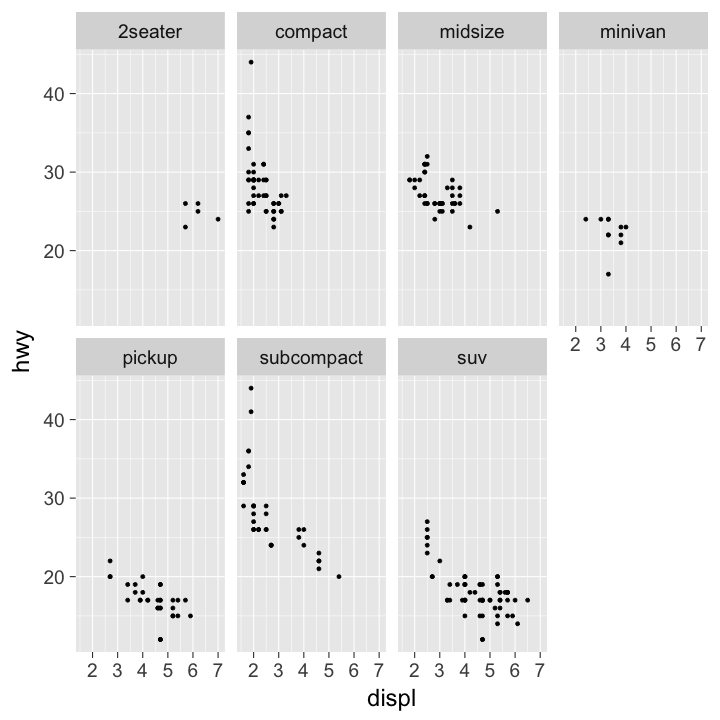

In [36]:
%%R -w 10 -h 10 -u in
ggplot(data = mpg) + 
  aes(x=displ, y=hwy) +
  geom_point() + 
  facet_wrap(~ class, nrow = 2)

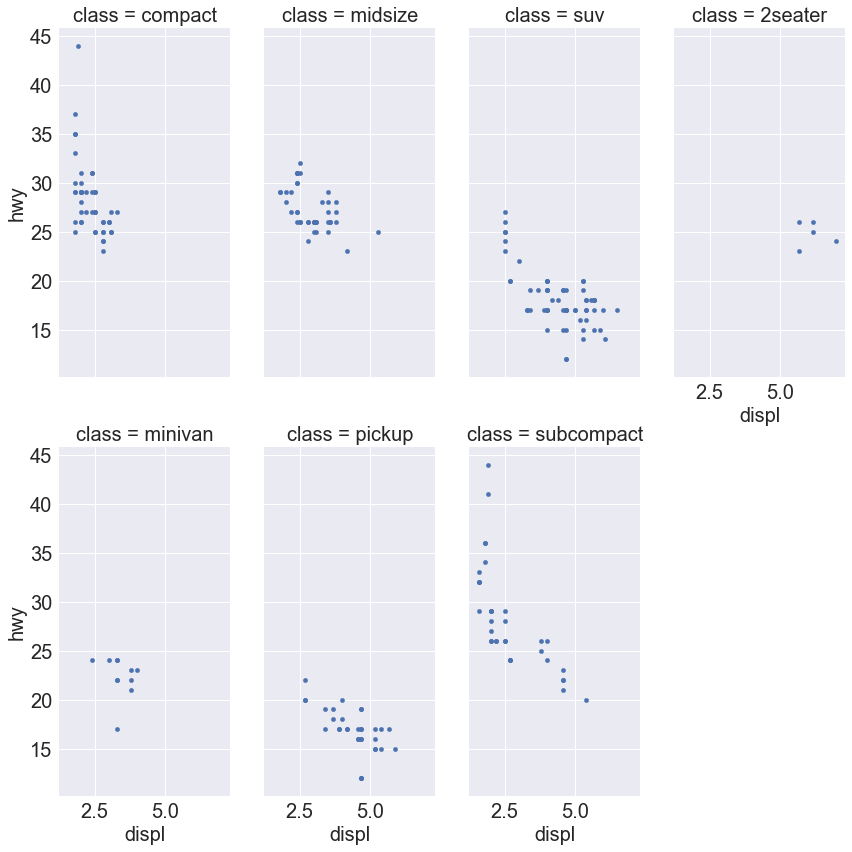

In [37]:
(mpg
 .pipe(sns.FacetGrid, 
       col="class", 
       col_wrap=4, 
       aspect=.5, 
       size=6)
 .map(plt.scatter, "displ", "hwy", s=20)
 .fig.subplots_adjust(wspace=.2, hspace=.2)
);

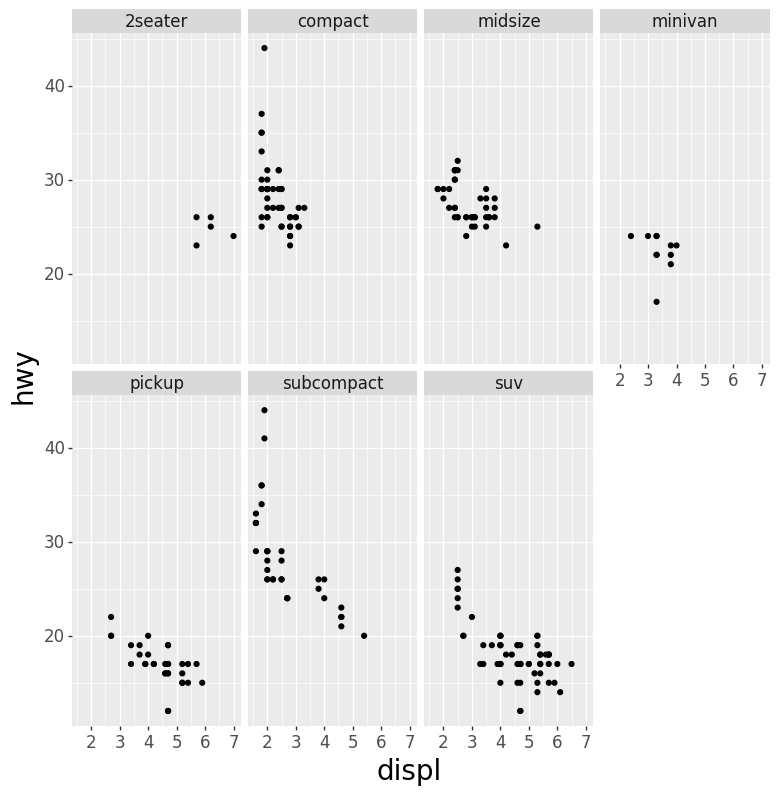

<ggplot: (-9223372036567657563)>

In [38]:
(ggplot(mpg.assign(c=mpg["class"])) + 
  aes(x="displ", y="hwy") +
  geom_point() +
  facet_wrap(" ~ c", nrow = 2))

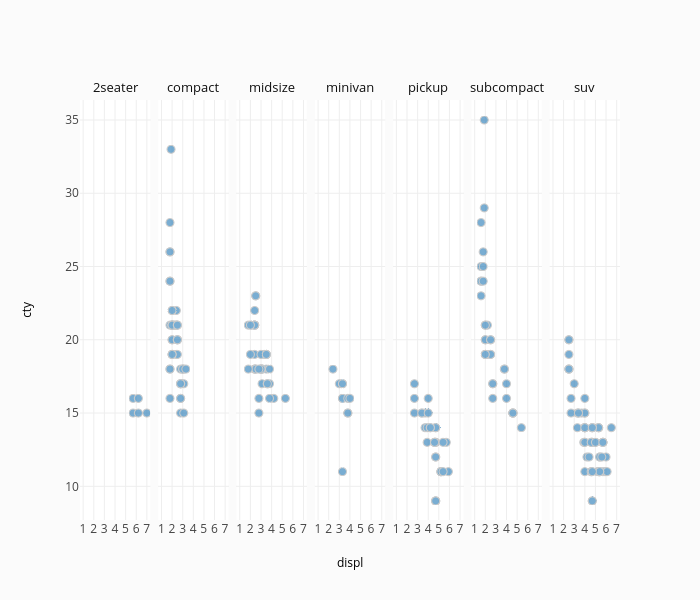

In [39]:
fig = FF.create_facet_grid(df=mpg,
                          x ='displ',
                          y = 'cty',
                          facet_col = 'class')
py.image.ishow(fig)

#### Scatter Plot with Facets

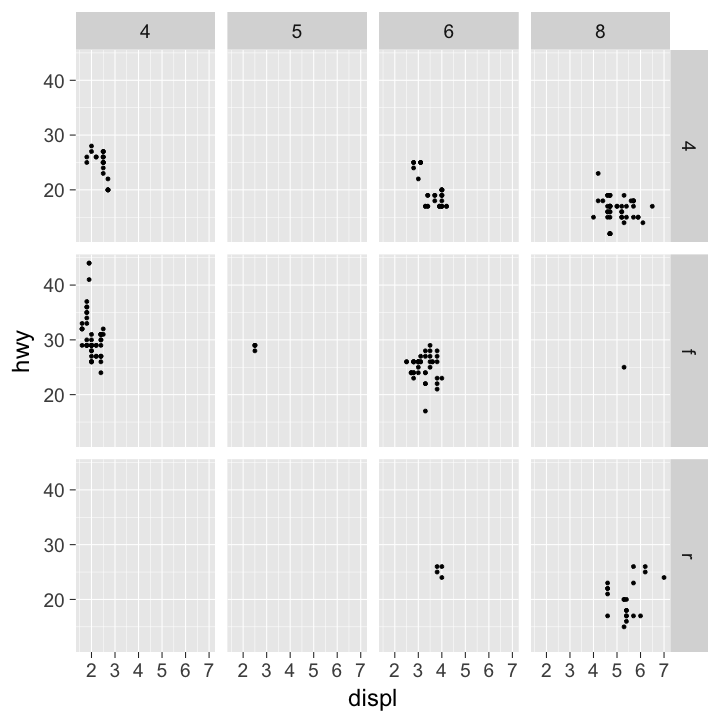

In [40]:
%%R -w 10 -h 10 -u in
ggplot(data = mpg) + 
  aes(x = displ, y = hwy) +
  geom_point() + 
  facet_grid(drv ~ cyl)

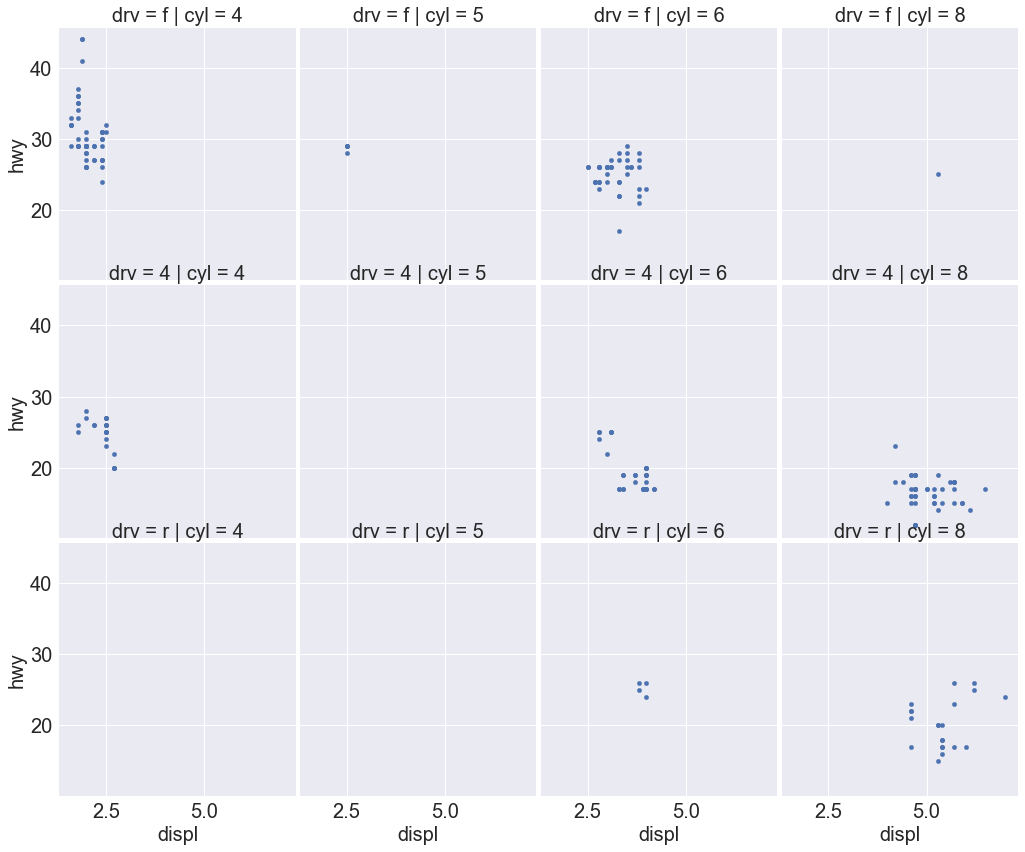

In [41]:
(mpg
 .pipe(sns.FacetGrid, 
       col="cyl", 
       row="drv", 
       aspect=.9, 
       size=4)
 .map(plt.scatter, "displ", "hwy", s=20)
 .fig.subplots_adjust(wspace=.02, hspace=.02)
);

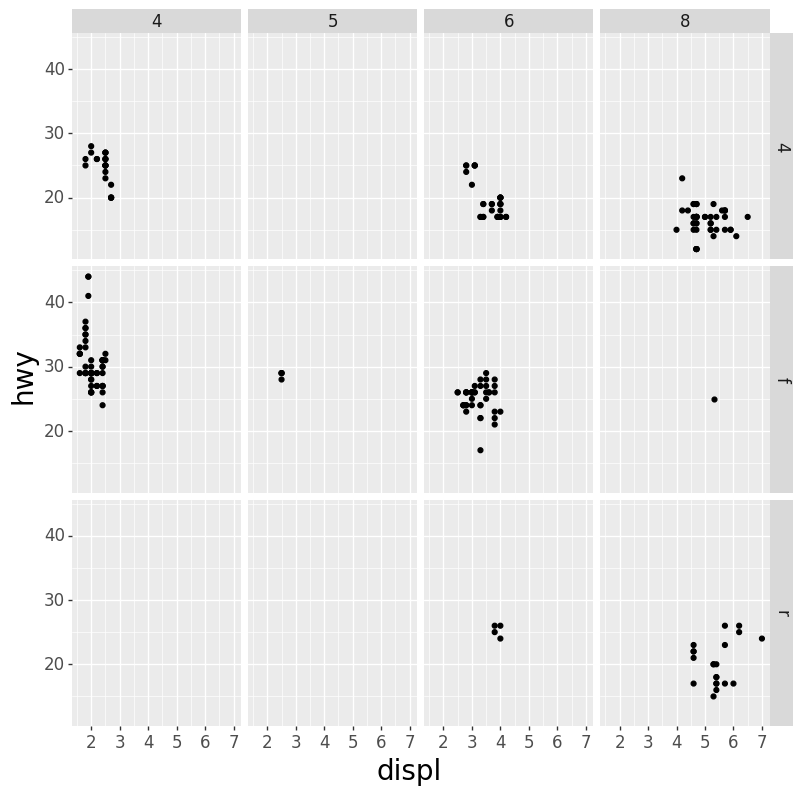

<ggplot: (287170126)>

In [42]:
(ggplot(mpg) + 
  aes(x="displ", y="hwy") +
  geom_point() + 
  facet_grid("drv ~ cyl"))

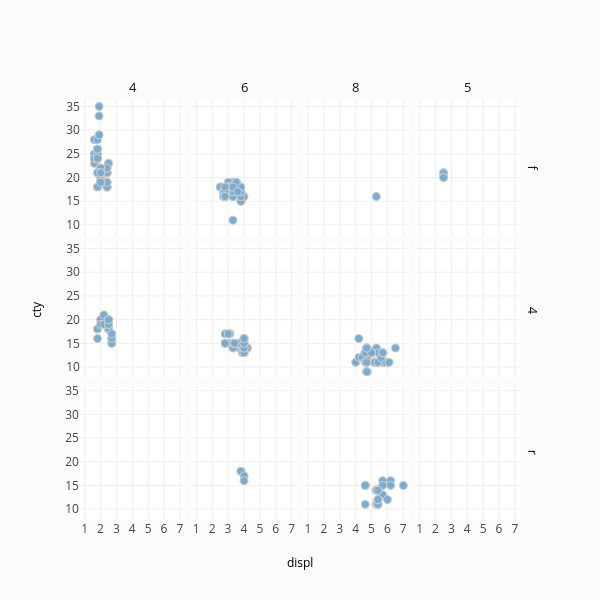

In [43]:
fig = FF.create_facet_grid(df=mpg,
                          x ='displ',
                          y = 'cty',
                          facet_col = 'cyl',
                          facet_row = 'drv')
py.image.ishow(fig)

Stacked Scatter and Smoothed Line Plot

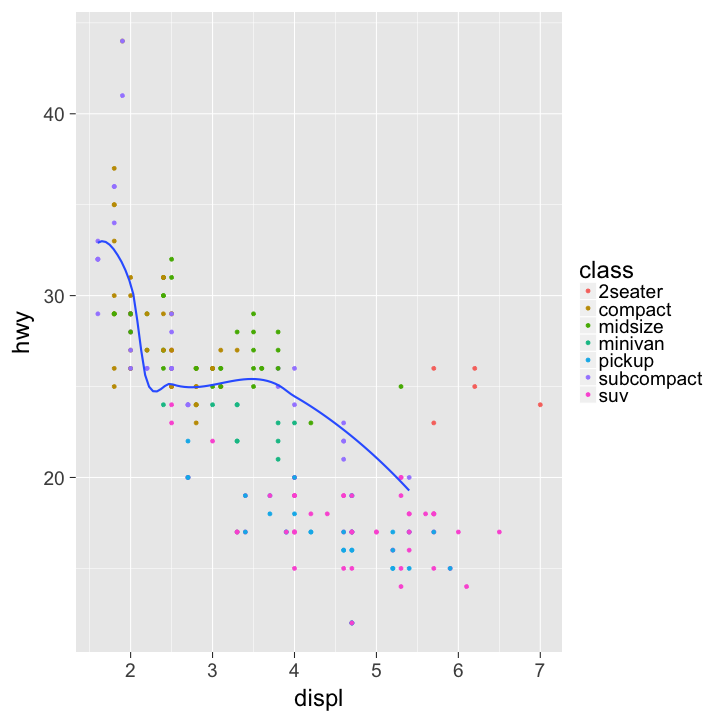

In [44]:
%%R -w 10 -h 10 -u in
subcompact = mpg[mpg$`class` == "subcompact", ]
ggplot(data = mpg, 
       mapping = aes(x = displ, y = hwy)) + 
  geom_point(mapping = aes(color = class)) + 
  geom_smooth(data = subcompact, 
              se = FALSE,
              method = 'loess')

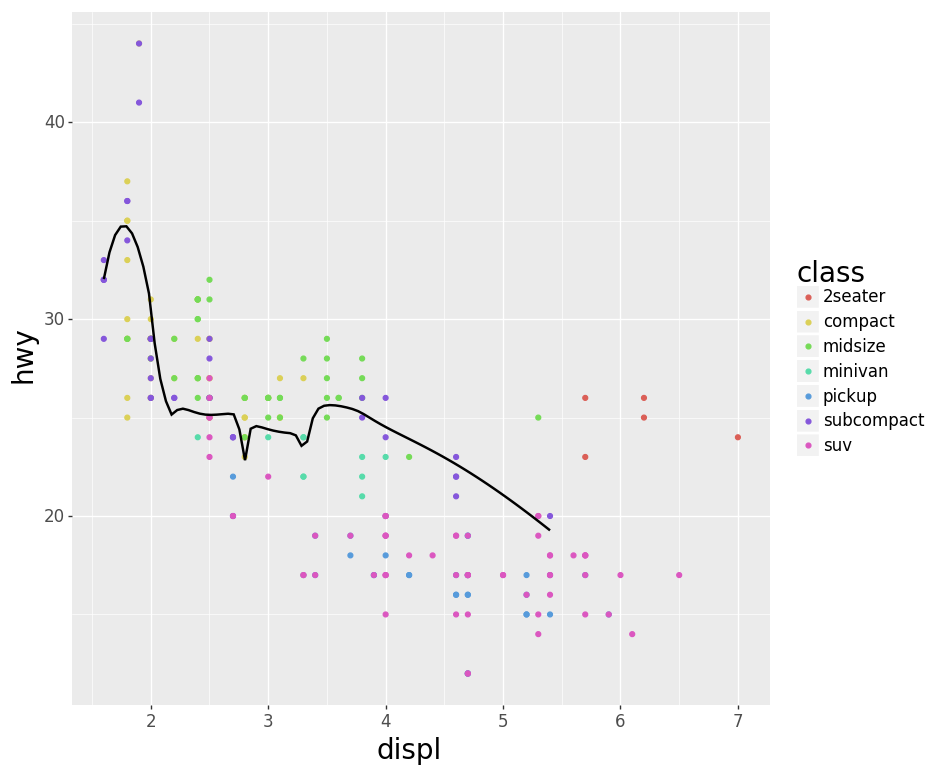

<ggplot: (-9223372036571331661)>

In [45]:
"""Notice the smoothed line isn't as smooth as it is in ggplot2."""
(ggplot(data=mpg, 
        mapping=aes(x="displ", y="hwy")) + 
  geom_point(mapping=aes(color = "class")) + 
  geom_smooth(data=mpg[mpg['class'] == "subcompact"], 
              se=False,
              method = 'loess'
             ))

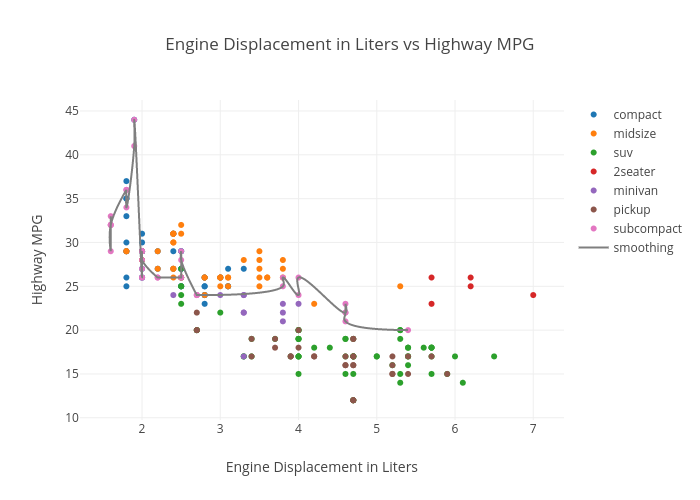

In [46]:
'''Plotly's builtin smoothing function is very weak'''

traces = []
for cls in mpg['class'].unique():
    traces.append({
        'type' : 'scatter',
        'mode' : 'markers',
        'x' : mpg.displ[mpg['class'] == cls],
        'y' : mpg.hwy[mpg['class'] == cls],
        'name' : cls
    })

    
subcompact = mpg[mpg['class'] == 'subcompact'].sort_values(by='displ')

traces.append({
    'type' : 'scatter',
    'mode' : 'lines',
    'x' : subcompact.displ,
    'y' : subcompact.hwy,
    'name' : 'smoothing',
    'line' : {
        'shape' : 'spline',
        'smoothing' : 1.3
    }
})
    
fig = {
    'data' : traces,
    'layout' : {
        'title' : 'Engine Displacement in Liters vs Highway MPG',
        'xaxis' : {
            'title' : 'Engine Displacement in Liters',
        },
        'yaxis' : {
            'title' : 'Highway MPG'
        }
    }
}
py.image.ishow(fig)

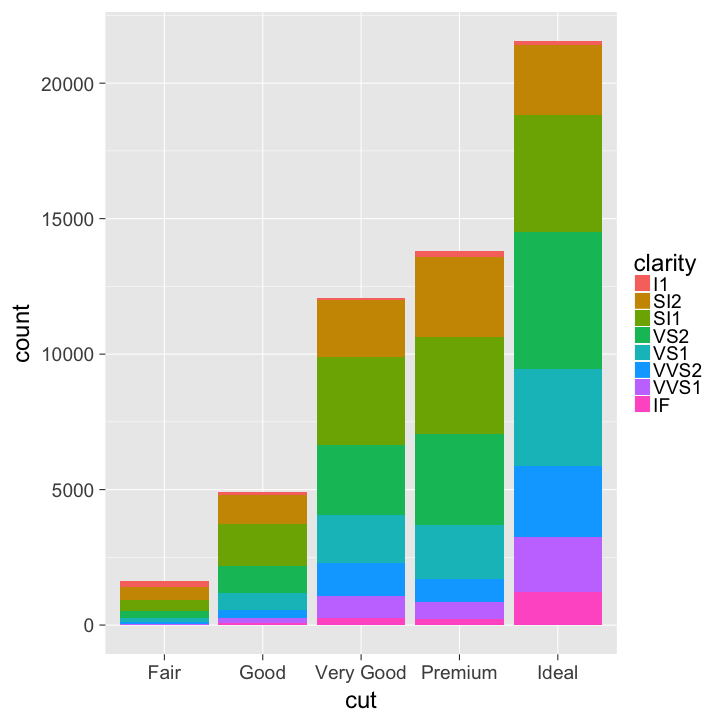

In [47]:
%%R -w 10 -h 10 -u in
ggplot(data = diamonds) + 
  aes(x = cut, fill = clarity) +
  geom_bar()

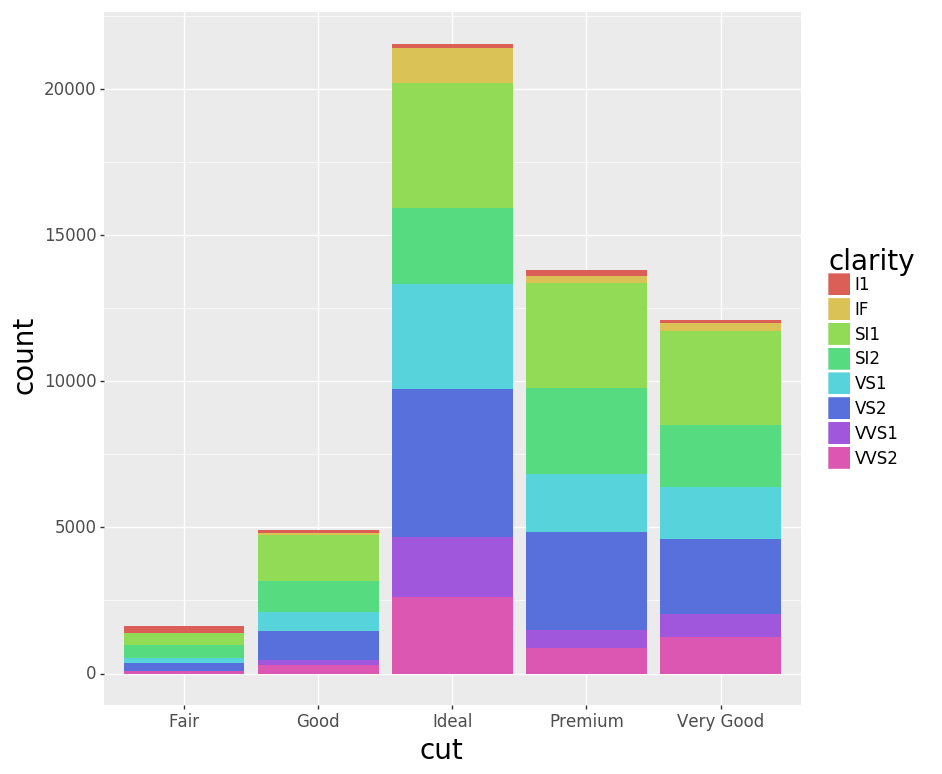

<ggplot: (-9223372036570949267)>

In [48]:
(ggplot(diamonds) + 
  aes(x="cut", fill="clarity") +
  geom_bar())

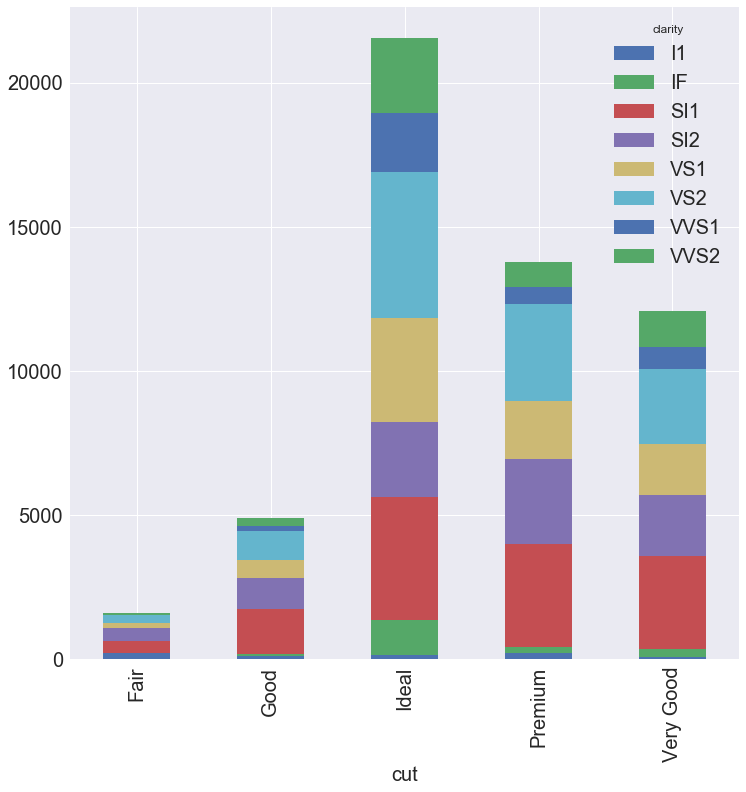

In [49]:
(diamonds
 .groupby(['cut', 'clarity'])
 .size()
 .unstack()
 .plot.bar(stacked=True)
);

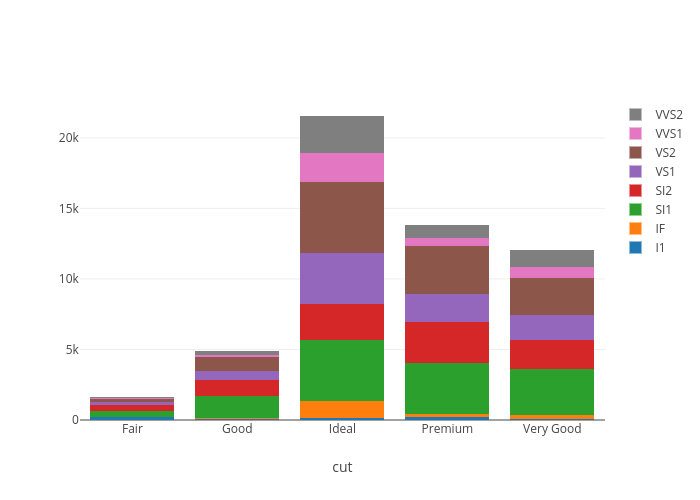

In [50]:
traces = []
newDiamond = diamonds.groupby(['cut','clarity']).size().unstack()
for c in newDiamond.columns:
    traces.append({
        'type' : 'bar',
        'x' : newDiamond.index,
        'y' : newDiamond[c],
        'name' : c
    })
fig = {
    'data' : traces,
    'layout' : {
        'barmode' : 'stack',
        'xaxis' : {
            'title' : 'cut'
        },        
    }
}
py.image.ishow(fig)

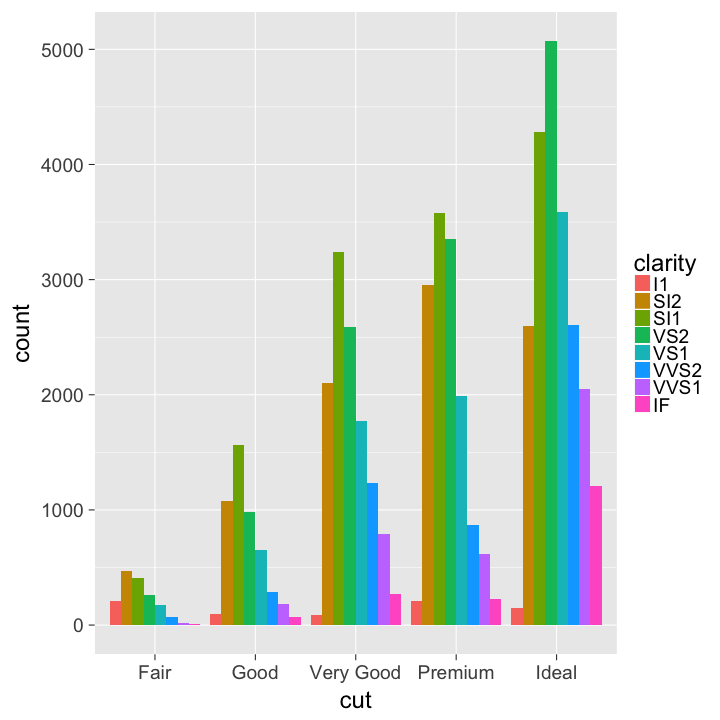

In [51]:
%%R -w 10 -h 10 -u in
ggplot(data = diamonds) + 
  aes(x = cut, fill = clarity) +
  geom_bar(position = "dodge")

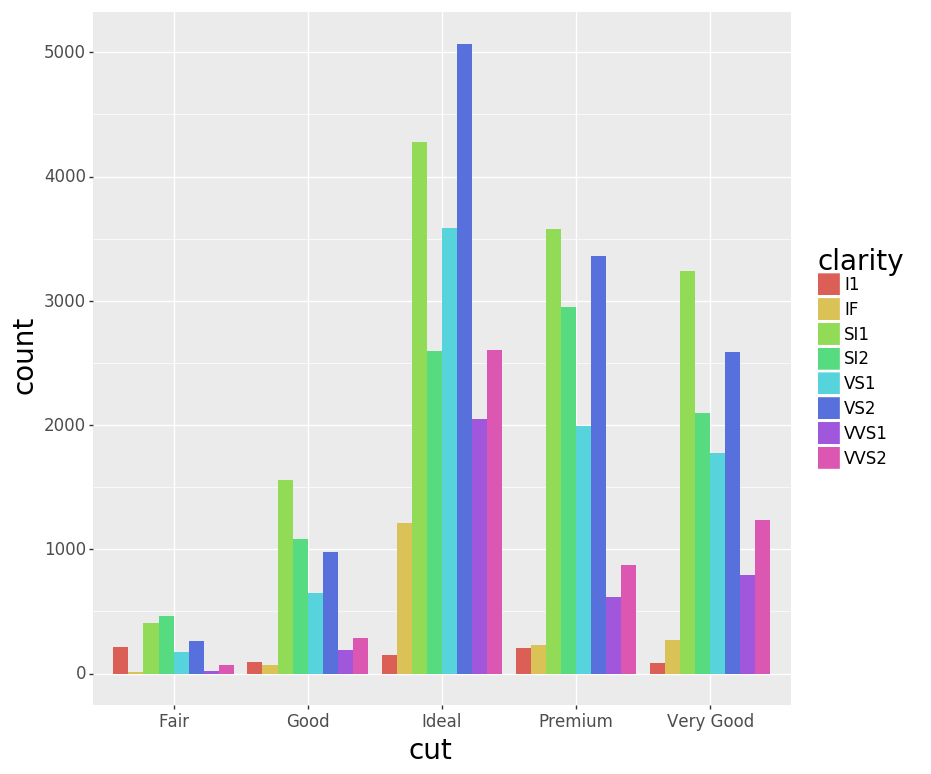

<ggplot: (-9223372036570400540)>

In [52]:
(ggplot(diamonds) + 
  aes(x='cut', fill='clarity') +
  geom_bar(position = "dodge"))


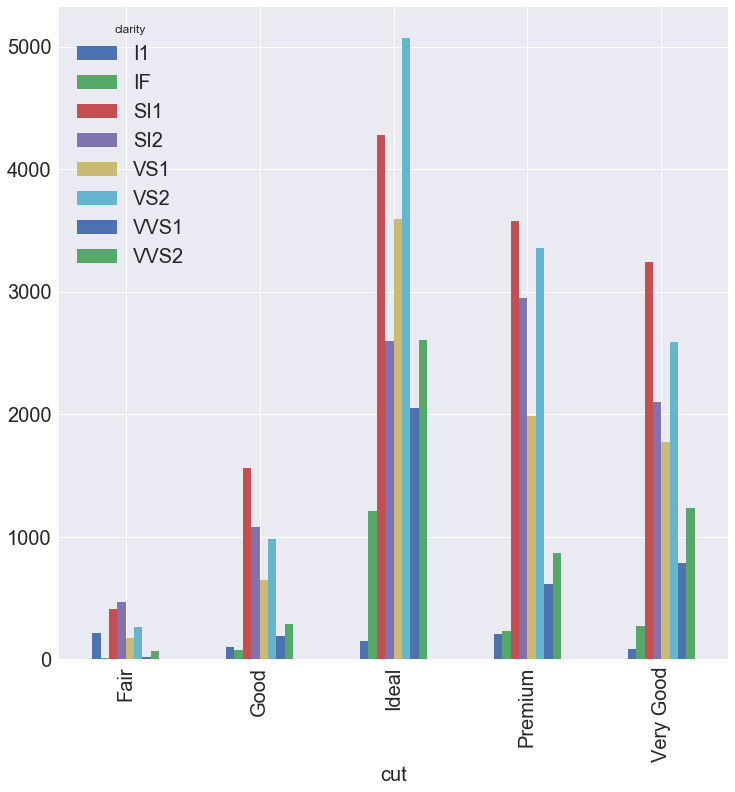

In [53]:
(diamonds
 .groupby(['cut', 'clarity'])
 .size()
 .unstack()
 .plot.bar()
);

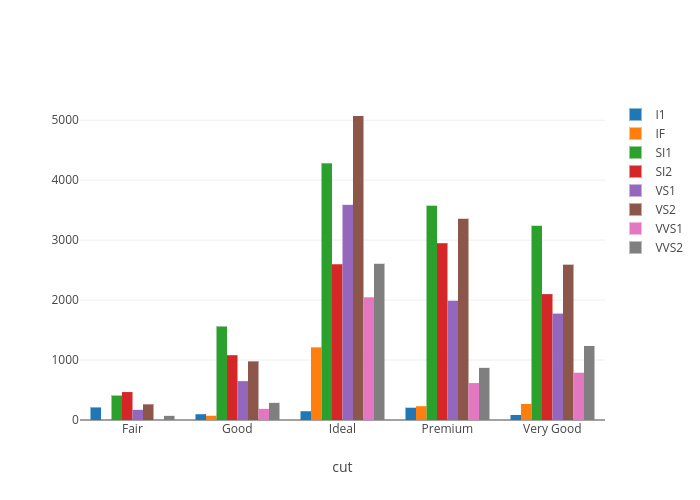

In [54]:
traces = []
newDiamond = diamonds.groupby(['cut','clarity']).size().unstack()
for c in newDiamond.columns:
    traces.append({
        'type' : 'bar',
        'x' : newDiamond.index,
        'y' : newDiamond[c],
        'name' : c
    })
fig = {
    'data' : traces,
    'layout' : {
        'barmode' : 'group',
        'xaxis' : {
            'title' : 'cut'
        },        
    }
}
py.image.ishow(fig)

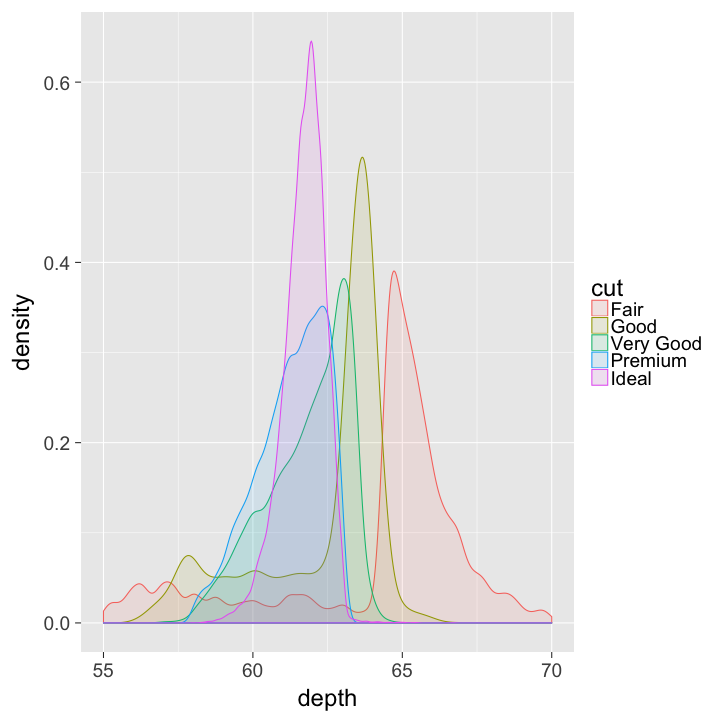

In [55]:
%%R -w 10 -h 10 -u in
ggplot(diamonds) +
  aes(depth, fill = cut, colour = cut) +
  geom_density(alpha = 0.1) +
  xlim(55, 70)

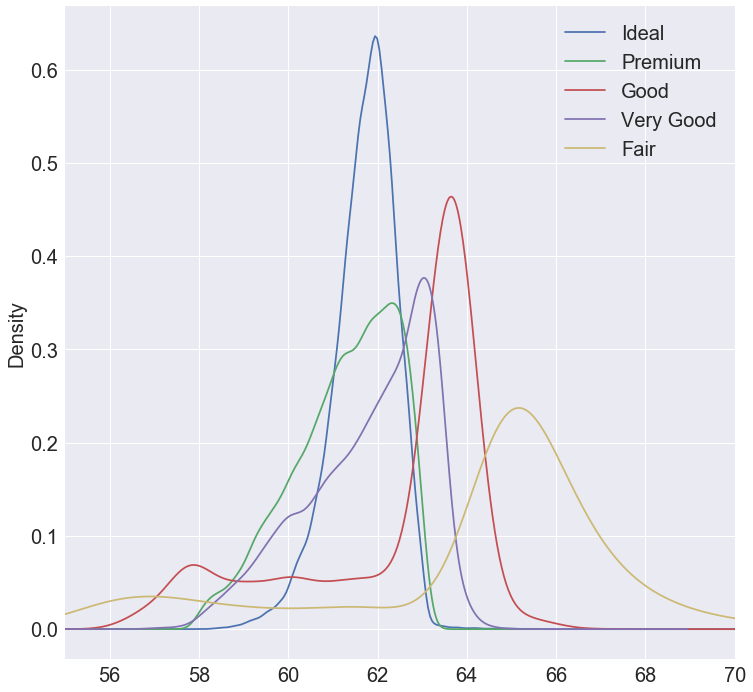

In [56]:
"""I don't know whether Pandas can fill a KDE curve.

This requires using some Matplotlib to get them to stack and to have a legend.
"""
fig, ax = plt.subplots()
ax.set_xlim(55, 70)
for cut in diamonds['cut'].unique():
    s = diamonds[diamonds["cut"] == cut]['depth']
    s.plot.kde(ax=ax, label=cut)
ax.legend()

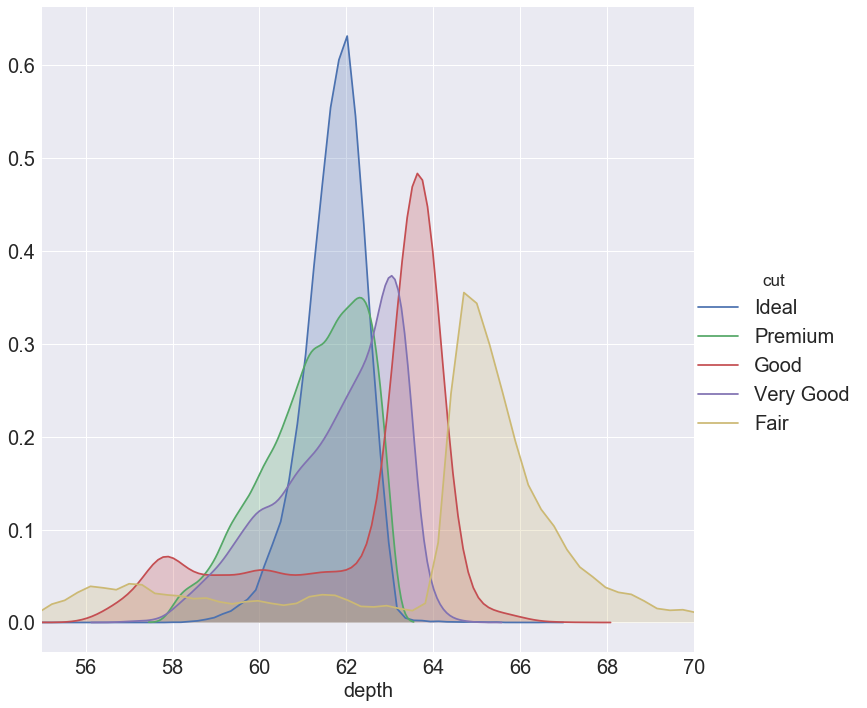

In [57]:
(sns
  .FacetGrid(diamonds, 
             hue="cut", 
             size=10, 
             xlim=(55, 70))
  .map(sns.kdeplot, 'depth', shade=True)
 .add_legend()
);

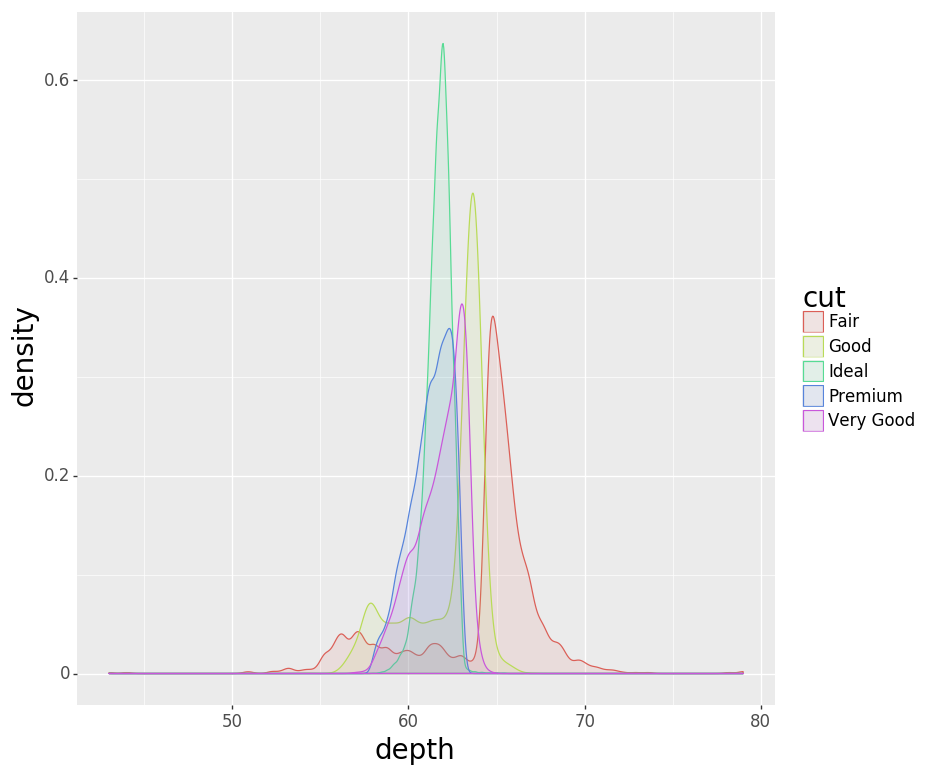

<ggplot: (-9223372036564636661)>

In [58]:
"""`+ xlim(55, 70)` results in an error."""
(ggplot(diamonds) +
  aes('depth', fill='cut', color='cut') +
  geom_density(alpha=0.1))

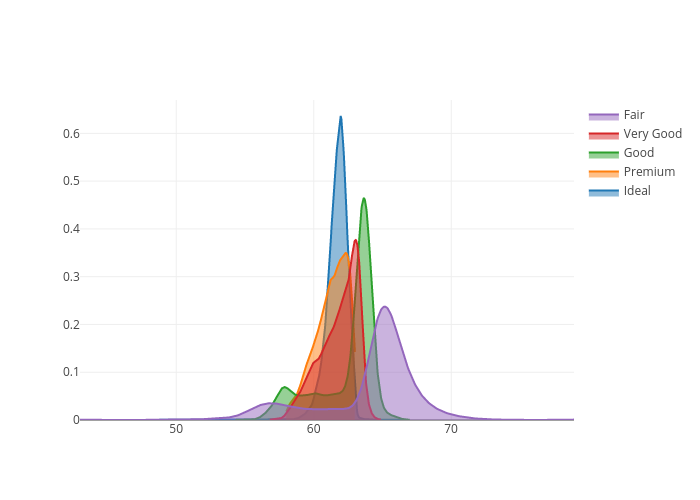

In [59]:
fig = FF.create_distplot(
                            [diamonds['depth'][diamonds['cut'] == c].values for c in diamonds.cut.unique()], 
                            diamonds.cut.unique(), 
                            show_hist=False,
                            show_rug=False
                           )
for d in fig['data']:
    d.update({'fill' : 'tozeroy'})

py.image.ishow(fig)

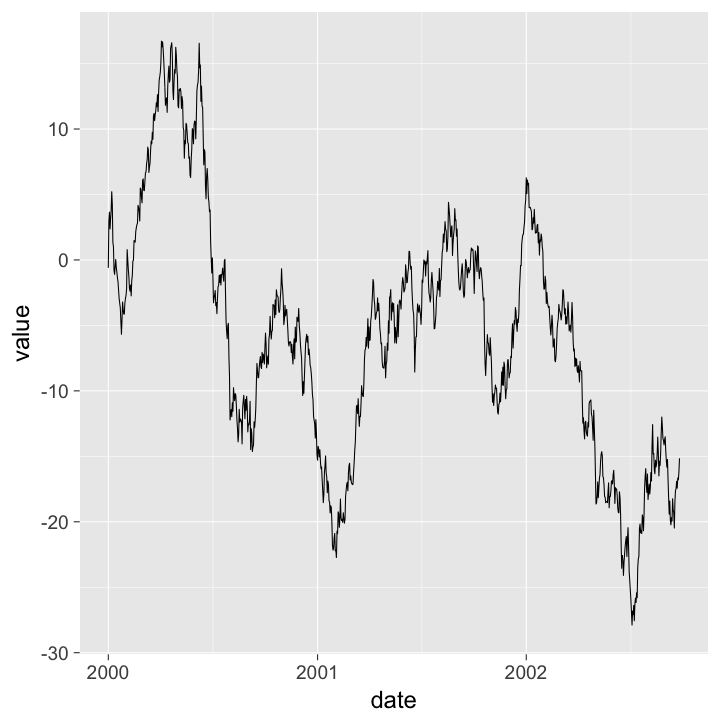

In [60]:
%%R -i ts -w 10 -h 10 -u in 
ggplot(ts) + aes(date, value) + geom_line()

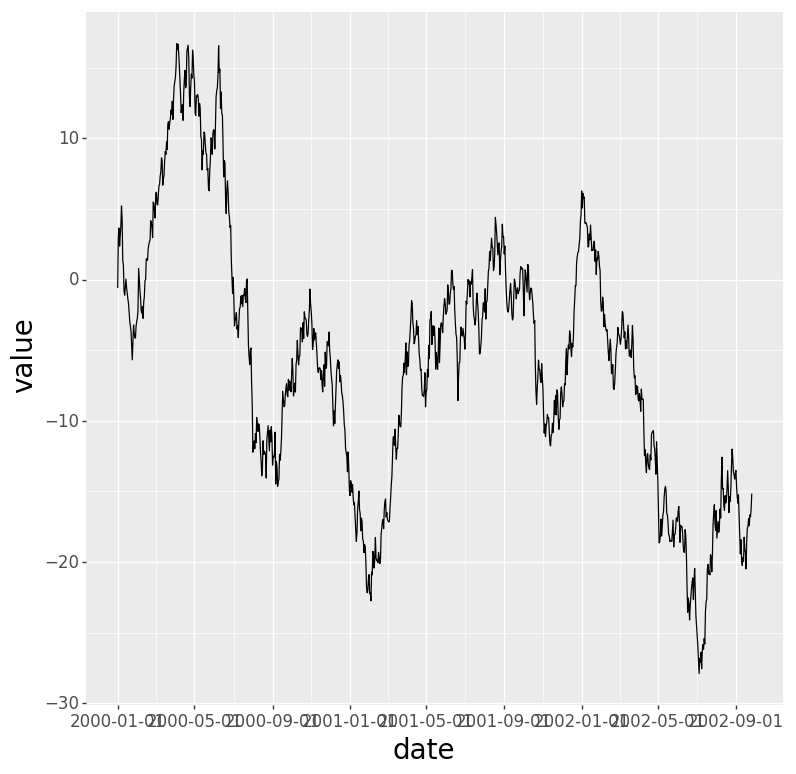

<ggplot: (287336456)>

In [61]:
(ggplot(ts) 
 + aes("date", "value") 
 + geom_line())

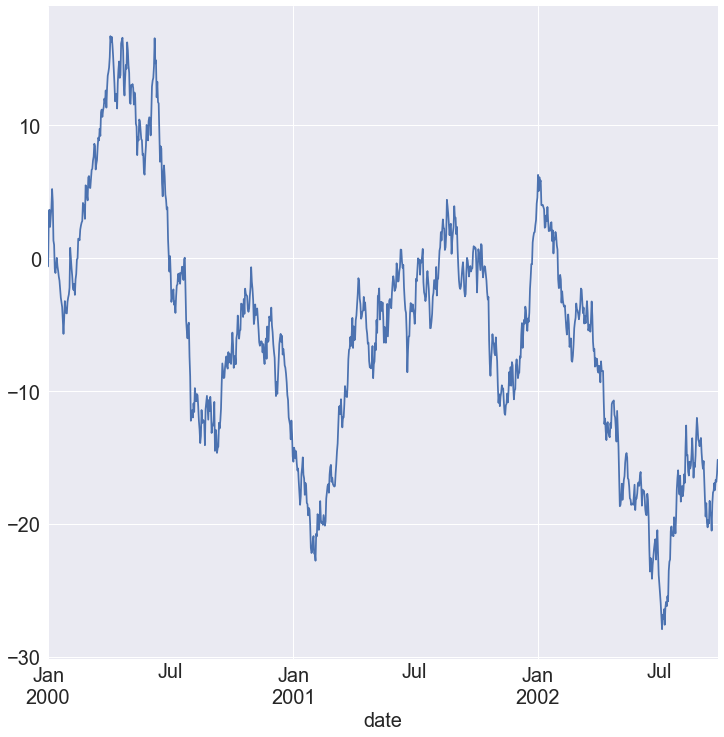

In [62]:
ts.set_index('date')['value'].plot()

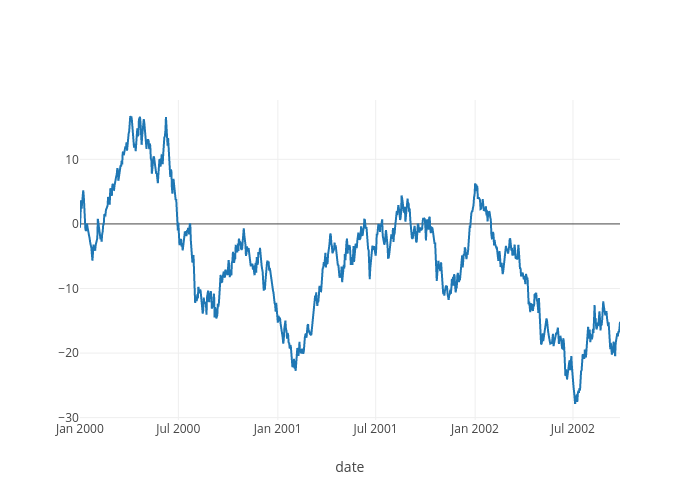

In [63]:
fig = {'data' : [{
    'type' : 'scatter',
    'mode' :'lines',
    'x' : ts.date,
    'y' : ts.value
}],
      'layout' : {
          'xaxis' : {
              'title' : 'date'
          }
      }}

py.image.ishow(fig)